In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.svm import SVC

import json
from pprint import pprint
import pandas as pd
import os
import re
import time
import matplotlib.pyplot as plt
%matplotlib inline
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

import pickle
import random
from pathlib import Path
import catboost as catb
from catboost import CatBoostClassifier
from pathlib import Path
from transliterate import translit

In [3]:
# Получаем список файлов в папки
ds = pd.read_json('2606.json')

In [4]:
data = ds.copy()
data.columns

Index(['_id', 'name_store', 'main_category_name', 'main_category_img_url',
       'category_name', 'category_img_url', 'category_permalink',
       'product_name', 'product_img_link', 'product_instamart_price',
       'product_original_unit_price', 'product_price', 'product_human_volume',
       'product_items_per_pack', 'product_price_type', 'product_stock',
       'product_stock_rate', 'product_max_stock_rate', 'product_discounted',
       'product_discount', 'product_unit_price', 'product_description',
       'product_description_original', 'product_properties'],
      dtype='object')

In [6]:
d = ds['product_properties']
d[0].keys()

dict_keys(['product_ingredients', 'product_nutrition', 'product_information'])

In [6]:
# Поиск значимых свойств
def type_prod(x):
    try:
        return x['product_information']['Тип продукта']
    except:
        try:
            return x['product_information']['Тип изделия']
        except:
            try:
                return (x['product_information']['Вид воды'])
            except:
                try:
                    return x['product_information']['Тип средства']
                except:
                    try:
                        return x['product_information']['Тип']
                    except:
                        try:
                            return x['product_information']['Вид каши']
                        except:
                             try:
                                return x['product_information']['Назначение']
                             except:
                                try:
                                    return x['product_information']['Технология']
                                except:
                                    try:
                                        return x['product_information']['Разновидность']
                                    except:
                                        try:
                                            return x['product_information']['Действующее вещество']
                                        except:
                                            try:
                                                return x['product_information']['Вид готового блюда']
                                            except:
                                                try:
                                                    return x['product_information']['Вид']
                                                except:
                                                    try:
                                                        return x['product_information']['Вид товара']
                                                    except:
                                                        try:
                                                            return x['product_information']['Тип товара']
                                                        except:
                                                            try:
                                                                return x['product_information']['Пол']
                                                            except:
                                                                return '-'
#                                                                 print(x['product_information'])    

In [8]:
# ds['manufacturer'] = ds['product_properties'].apply(lambda x: (x['product_information']['manufacturer']))
# ds['brand'] = ds['product_properties'].apply(lambda x: (x['product_information']['brand']))
ds['properties'] = ds['product_properties'].apply(lambda x: type_prod(x))

In [34]:
# Чтение словаря (список магазинов) из файла
with open('shops_dict', 'r') as f:
    shops_dict = json.loads(f.read())

In [ ]:
#Запись словаря в файл    
with open('shops_dict', 'w', encoding='utf-8') as f:
    f.write(json.dumps(shops_dict))

In [35]:
def give_me_dataset(data):
    
    # regex for all nums and len(word)>3 -> new column product_group_name
    df = data.copy()
    df.loc[(df['product_price_type'] == 'per_kilo'), 'product_price'] = df['product_unit_price']
    df.loc[(df['product_price_type'] == 'per_kilo'), 'product_human_volume'] = '1 кг'
    df =  df[(df['main_category_name'] != 'Алкоголь')]
    
    # Создание колонки для группировки продуктов
    
    df.reset_index(inplace=True)
    
    re1 = r"\d+" # nums
    re2 = '\w{3,30}' # words (цифры , буквы и др символы)
    re11 = '[a-zа-яё]+\d+|\d+[a-zа-яё]+|\d+\,*\d+\%|\w[а-яё,a-z]{2,30}' #буквы, цифры с буквами   #'\w[а-яё,a-z]{2,30}\d*'   # words
    re3 = r"\d+\s\b[млкгшт]{1,2}\b|\d+\,*\d+\s\b[млкгшт]{1,2}" 
    
    list_of_names = []
    list_of_names_orig = []
    for num, i in enumerate(df.product_name): 
        try:
            weight = re.findall(re3, df.product_human_volume[num])[0].split()
            if (weight[0] == '1' and weight[1] == 'шт'):
                name = ' '.join(sorted(re.compile("(%s)" % re2).findall(i.lower())))
                name_orig = df.product_name[num].lower()              
            else:
                name = str(weight[0]) + ' ' + ' '.join(sorted(re.compile("(%s)" % re11).findall(i.lower()))) 
                name_orig = str(weight[0]) + ' ' + ' '.join(re.compile("(%s)" % re11).findall(i.lower()))
        except:
            name = ' '.join(sorted(re.compile("(%s)" % re11).findall(i.lower())))
            name_orig = ' '.join(re.compile("(%s)" % re11).findall(i.lower()))

        list_of_names.append(name)
        list_of_names_orig.append(name_orig)
    df.insert(loc=0, column='product_group_name', value=list_of_names) 
    df.insert(loc=0, column='product_group_name_orig', value=list_of_names_orig) 
    df['product_group_name'] = df['product_group_name'].apply(lambda x: x.replace(' metro chef', ''))
    df['product_group_name'] = df['product_group_name'].apply(lambda x: x.replace(' бзмж', ''))
    df['product_group_name_orig'] = df['product_group_name_orig'].apply(lambda x: x.replace(' metro chef', ''))
    df['product_group_name_orig'] = df['product_group_name_orig'].apply(lambda x: x.replace(' бзмж', '')) 
        
       
    # delete duplicates in each shop and make clear_dataset  

    clear_dataset = pd.DataFrame() 
    for shop in df['name_store'].unique():
        df_temp = df[df['name_store'] == shop]
        df_temp.drop_duplicates(subset='product_group_name', inplace=True)
        try:
            df_temp.loc[df_temp['name_store'] == shop, 'name_store'] = shops_dict.get(shop, [])
        except:
            print(shop, ' - new shop!')
            
        
        clear_dataset = pd.concat([clear_dataset, df_temp])
        
#     Выключим этот блок
    if 0:
        
        # delete inedible goods
        clear_dataset.drop(clear_dataset[clear_dataset.product_human_volume == '50 м'].index, inplace=True)

    #      Создание колонки 'total_weight_kg' - вес продукта
        volume_list = clear_dataset['product_human_volume'].apply(lambda x: x.replace(',', '.').split()).to_list()
        new_list = []
        flag = [0] * len(volume_list)
        re3 = r"\d+\,*\d+\s\b[млкг]{1,2}\b"
        re4 = r"\d+\,*\d+\s"

        for num, i in enumerate(volume_list):
            if len(i) == 4:
                volume_list[num] = str(float(i[0]) * float(i[3])) + ' ' + i[1]
            if len(i) == 2 and i[1] == 'шт':
                try:
                    volume_list[num] = re.compile("(%s)" % (re3)).findall(str(clear_dataset.product_name.to_list()[num]))[0].split()
                    volume_list[num][0] = volume_list[num][0].replace(',', '.')  
                except:
                    volume_list[num] = '1 шт'

        for num, i in enumerate(volume_list):
            if len(i) == 2:
                if i[1] == 'г' or i[1] == 'мл':
                    new_list.append(round(float(i[0]) / 1000, 2))
                elif i[1] == 'мг':
                    new_list.append(round(float(i[0]) / 1000000, 2))
                elif i[1] == 'л':
                    new_list.append(round(float(i[0]), 2))
                elif i[1] == 'шт':
                    new_list.append(0)
                    flag[num] = 1
                elif i[1] == 'кг':
                    new_list.append(round(float(i[0])))
                else:
                    new_list.append(0)
                    flag[num] = 1
            else:
                new_list.append(0)
                flag[num] = 1


        discount = [round((1 - (i / j)) * 100) for i, j in zip(clear_dataset.product_unit_price.to_list(), clear_dataset.product_original_unit_price.to_list())]

        clear_dataset.drop(['product_discount'], axis=1, inplace=True)
        clear_dataset.insert(loc=20, column='product_discount', value=discount)   
        clear_dataset.insert(loc=0, column='total_weight_kg', value=new_list)
        clear_dataset.insert(loc=1, column='total_weight_flag', value=flag)
        clear_dataset['slug_product_name'] = clear_dataset['product_name'].apply(lambda x: '-'.join(translit(x, language_code='ru', reversed=True).lower().replace("\'", '').replace(",", '-').split(' ')))
        clear_dataset['slug_main_category_name'] = clear_dataset['main_category_name'].apply(lambda x: '-'.join(translit(x, language_code='ru', reversed=True).lower().replace("\'", '').replace(",", '').split(' ')))
        clear_dataset['slug_category_name'] = clear_dataset['category_name'].apply(lambda x: '-'.join(translit(x, language_code='ru', reversed=True).lower().replace("\'", '').replace(",", '').split(' ')))


        for i in range(0, math.ceil(clear_dataset.shape[0]/10000)):
            rg1 = int(f'{i}0000')
            rg2 = int(f'{i+1}0000')
            with open(f'data/sber_{i}.json', 'w', encoding='utf-8') as file:
                clear_dataset[rg1:rg2].to_json(file, force_ascii=False, orient='records')  
            
    return clear_dataset

In [36]:
%%time
new_df = give_me_dataset(data)

<ipython-input-35-0ada41574f87>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop_duplicates(subset='product_group_name', inplace=True)
<ipython-input-35-0ada41574f87>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop_duplicates(subset='product_group_name', inplace=True)
<ipython-input-35-0ada41574f87>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop_duplicates(subset='product_group_name', inplac

Wall time: 6.82 s


## Обработка текста

In [37]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer


sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_prod_name(txt):
     
    re1 = '[a-zа-яё]+\d+|\d+[a-zа-яё]+|\d+\,*\d+\%|\w[а-яё,a-z]{2,30}' #буквы, цифры с буквами
    txt = str(txt)
    txt = re.sub("[^а-яА-Яa-zA-Z\-\_Ёё]"," ",txt) 
    # удаляем лишние пробелы
    txt = ' '.join(txt.split())
    # приводим к нижнему регистру и удаляем лишние символы
    txt = ' '.join(re.compile("(%s)" % re1).findall(txt.lower()))
    txt = "".join(c for c in txt if c not in exclude)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

new_df['product_name_prep'] = new_df['product_name'].apply(preprocess_prod_name)
new_df['product_name_prep'] = new_df['product_name_prep'].apply(lambda x: x.replace(' бзмж', '').replace(' metro chef', ''))

In [38]:
new_df[['product_name','product_name_prep']]

,product_name,product_name_prep
0,Петрушка,петрушка
1,Петрушка в горшочке 120 г,петрушка горшочек
2,Петрушка 100 г,петрушка
3,Плавленый сыр Hochland Чизбургер 8 ломтиков 45...,плавленый сыр hochland чизбургер ломтик
4,Помидоры черри Мое Лето желтые круглые без вет...,помидор черри мой лето жёлтый круглый ветка
...,...,...
134973,Семечки подсолнечные От Мартина Отборные жарен...,семечко подсолнечный мартин отборный жареный
134974,Семечки подсолнечные От Мартина Молодежные жар...,семечко подсолнечный мартин молодёжный жареный
134975,Изюм Первым делом без косточки 70 г,изюм первый дело косточка
134976,Финики сушеные 200 г,финик сушёный


In [55]:
# до обработки
len(new_df['product_name'].unique())

99803

In [56]:
# После обработки
len(new_df['product_name_prep'].unique())

91064

## Изучение категорий товаров

In [23]:
def print_main_cat_dict(df):
    category = df['main_category_name'].unique()
    dict = {}
    for name in category:
        dict[name] = (df.loc[new_df['main_category_name'] == name, 'category_name'].unique().tolist())
    pprint(dict)

In [23]:
new_df['name_store'].value_counts()

okey              29856
globus            28768
auchan            25943
lenta             22552
metro             17902
victoria           8220
dixy               3291
magnit_express     3246
fixpricefd         2238
Name: name_store, dtype: int64

In [27]:
shop = np.unique(new_df['name_store'].values)
for name in shop:
    print('Магазин - ', name, '\n\n', new_df.loc[new_df['name_store'] == name, 'main_category_name'].value_counts(), '\n\n')

Магазин -  Ашан 

 Дача, сад                                   2886
Рецепты                                     2735
Косметика, гигиена                          2469
Детские товары                              1453
Спецпредложения АШАН                        1391
Летний отдых, барбекю                       1328
Сладости                                    1241
Кухня                                        908
Товары для дома                              902
Бытовая химия, уборка                        780
Молоко, сыр, яйца, растительные продукты     743
Товары для животных                          678
Макароны, крупы, мука                        648
Канцелярия, книги                            578
Бытовая техника, электроника                 535
Замороженные продукты                        450
Колбасы, сосиски, деликатесы                 424
Мелочи возле кассы                           398
Автотовары                                   363
Одежда, обувь, аксессуары                    348
К

In [41]:
train = new_df.loc[new_df['name_store'] == 'Окей']

In [42]:
train = train[train['category_name'] != 'Продукты с бесплатной доставкой']

In [26]:
category_make_dict = {
    'Автотовары': ['Аксессуары для шиномонтажа',
                'Аксессуары для автомобилистов',
                'Аккумуляторы',
                'Перевозка багажа',
                'Автомобильный свет',
                'Стеклоочистители',
                'Автопроводка и предохранители',
                'Сопутствующие товары',
                'Внешние дополнительные элементы',
                'Аварийные принадлежности',
                'Фильтры',
                'Ароматизаторы и увлажнители',
                'Подушки, валики под шею',
                'Зеркала',
                'Органайзеры и сумки',
                'Коврики',
                'Обустройство салона',
                'Чехлы, накидки, заглушки для сидений',
                'Воски и полироли',
                'Аксессуары для мытья и полировки',
                'Масла',
                'Салфетки, полотенца',
                'Холодная сварка',
                'Смазочные материалы',
                'Дистиллированная вода',
                'Присадки',
                'Преобразователи ржавчины',
                'Тормозные жидкости',
                'Промывки',
                'Средства для очистки',
                'Уход за стеклами',
                'Антифризы и охлаждающие жидкости',
                'Автошампуни',
                'Пылесосы',
                'Покраска авто',
                'Уход за салоном'],
 'Бытовая техника, электроника': ['Прочие аксессуары',
                                  'Игры, хобби',
                                  'Наушники, колонки',
                                  'Телевизоры',
                                  'Прочая техника',
                                  'Аксессуары для телефонов, гаджетов',
                                  'Кабели, адаптеры',
                                  'Напольные весы',
                                  'Карты памяти, флешки',
                                  'Аксессуары для ТВ, аудио, видео',
                                  'Косметические приборы',
                                  'Климатическая техника',
                                  'Умный дом',
                                  'Прочая техника для кухни',
                                  'Грили, аэрогрили',
                                  'Уборка',
                                  'Стирка, уход за одеждой',
                                  'Укладка волос',
                                  'Бритье и стрижка',
                                  'Мыши, клавиатуры, геймпады',
                                  'Кухонные весы',
                                  'Мясорубки, мультирезки',
                                  'Мультипекари, тостеры',
                                  'Миксеры, блендеры',
                                  'Микроволновки, печи',
                                  'Мультиварки, пароварки',
                                  'Соковыжималки',
                                  'Светильники, лампы, дверные звонки',
                                  'Кофеварки, кофемашины',
                                  'Удлинители, сетевые фильтры',
                                  'Электрочайники, термопоты',
                                  'Лампочки',
                                  'Батарейки, аккумуляторы'],
 'Бытовая химия, уборка': ['Domestos, Cif, Glorix',
                           'Средства от насекомых, грызунов',
                           'Ванна, туалет',
                           'Швабры, веники, ведра, тазы',
                           'Средства для стирки',
                           'Отбеливатели, пятновыводители',
                           'Кондиционеры, ополаскиватели',
                           'Средства для мытья посуды',
                           'Для пола, ковров, мебели',
                           'Для прочистки труб',
                           'Для кухни',
                           'Стёкла, зеркала',
                           'Средства для бытовой техники',
                           'Уход за обувью, одеждой'],
 'Вода, соки, напитки': ['Энергетические напитки',
                         'Лёд',
                         'Безалкогольное пиво, вино',
                         'Соки, нектары, морсы',
                         'Газированные напитки',
                         'Виноградный сок',
                         'Растительные напитки',
                         'Детская вода, напитки',
                         'Холодный чай',
                         'Сок маракуйи',
                         'Холодные напитки',
                         'Газированная вода'],
 'Всё для ремонта': ['Растворители, очистители',
                     'Канаты, тросы',
                     'Средства защиты',
                     'Герметики',
                     'Монтажная пена',
                     'Краска, грунты',
                     'Монтажные ленты',
                     'Хомуты',
                     'Дюбели, дюбель-гвозди, гвозди',
                     'Клей',
                     'Ящики, полки для инструментов',
                     'Саморезы, шурупы',
                     'Крючки, клипсы, держатели',
                     'Бензо, пневмо, паяльный инструмент',
                     'Уровни',
                     'Фурнитура для мебели',
                     'Тепловентиляторы',
                     'Аксессуары для утепления',
                     'Рулетки',
                     'Пистолеты для клея, пены, герметика',
                     'Мойки высокого давления',
                     'Аккумуляторы для инструмента, зарядные устройства',
                     'Компрессоры',
                     'Лобзики',
                     'Дрели, шуруповерты, гайковерты',
                     'Клещи, зажимы',
                     'Шлифовальные элементы',
                     'Щетки',
                     'Ключи',
                     'Ножовки, надфили, напильники, стамески, стусло',
                     'Шпатели, скребки',
                     'Ножи, ножницы, шилья, лезвия, стеклорезы',
                     'Оснастка для инструментов',
                     'Наборы ручных инструментов',
                     'Отвертки',
                     'Малярный инструмент',
                     'Плоскогубцы',
                     'Бокорезы, кусачки, болторезы',
                     'Кувалды, молотки, киянки, монтировки'],
 'Готовая еда': ['Завтраки',
                 'Вторые блюда, супы',
                 'Салаты, закуски',
                 'Сэндвичи, пицца, пирожки'],
 'Дача, сад': ['Тенты, гамаки, садовая мебель',
               'Посуда для пикника',
               'Настольные игры',
               'Защита от грызунов',
               'Защита от насекомых',
               'Термосы, сумки-холодильники',
               'Надувная мебель, матрасы',
               'Опоры для растений, ограждения',
               'Водяные насосы, умывальники',
#                'Косметические средства',
               'Биотуалеты, химия',
               'Горшки, кашпо, корзины для цветов',
               'Шланги, насадки, системы полива',
               'Садовая техника, аксессуары',
               'Садовый инвентарь',
               'Садовый инструмент',
               'Освещение',
               'Парники, укрывной материал',
               'Уголь, дрова, розжиг',
               'Садовые фигуры, освещение',
               'Одежда, обувь, средства защиты',
               'Опрыскиватели, лейки, ведра',
               'Банные принадлежности',
               'Мангалы, грили',
               'Шампуры, решетки, принадлежности',
               'Удобрения, защита растений',
               'Семена, саженцы, рассада',
               'Грунты'],
 'Детские товары': ['Белье, обувь, аксессуары',
                    'Досуг и творчество',
                    'Товары для творчества',
                    'Книги для малышей',
                    'Безопасность ребенка',
                    'Лепка',
                    'Рисование',
                    'Тетради, блокноты, дневники',
                    'Рукоделие, поделки',
                    'Активные игры',
                    'Рюкзаки, сумки и пеналы',
                    'Игрушечное оружие',
                    'Музыкальные инструменты',
                    'Школьные принадлежности',
                    'Игровые наборы и фигурки',
                    'Пазлы, мозаика',
                    'Игрушки для малышей',
                    'Все для купания',
                    'Конструкторы',
                    'Стирка и уход за бельем',
                    'Товары для кормления',
                    'Уход за кожей',
                    'Пустышки, прорезыватели',
                    'Куклы, аксессуары',
                    'Мытье посуды, игрушек',
                    'Шампуни, гели, мыло',
                    'Зубные пасты, щетки',
                    'Аксессуары',
                    'Игрушечный транспорт',
                    'Мягкие игрушки',
                    'Игрушки-антистресс',
                    'Пелёнки и клеёнки',
                    'Молочные продукты',
                    'Солнцезащитные средства',
                    'Сладости, сухие завтраки',
                    'Молочные смеси',
                    'Подгузники, трусики',
                    'Салфетки, диски, палочки',
                    'Пюре',
                    'Каши',
                    'Соки, воды, напитки'],
 'Замороженные продукты': ['Рыба, морепродукты',
                           'Фрукты, ягоды',
                           'Мясо, птица',
                           'Сливочный пломбир',
                           'Мороженое',
                           'Овощи, смеси, грибы',
                           'Пельмени, вареники',
                           'Тесто',
                           'Горячая штучка',
                           'Сладости',
                           'Блины, оладьи, сырники',
                           'Мороженое',
                           'Мясные полуфабрикаты',
                           'Готовая еда',
                           'Пицца',
                           'Рыбные полуфабрикаты',
                           'Хлеб, сэндвичи, выпечка'],
 'Канцелярия, книги': ['Образование',
                       'Психология и саморазвитие',
                       'Дом, хобби, досуг',
                       'Детская литература',
                       'Художественная литература',
                       'Красота, здоровье и спорт',
                       'Корректоры для текста',
                       'Клей',
                       'Канцелярские мелочи',
                       'Аксессуары для офиса',
                       'Клейкие ленты и держатели',
                       'Папки и файлы',
                       'Маркеры и фломастеры',
                       'Журналы, газеты',
                       'Канцелярские ножницы и ножи',
                       'Карандаши',
                       'Бумажные изделия',
                       'Циркули, готовальни',
                       'Настольные подставки и наборы',
                       'Бумага для печати',
                       'Ручки, роллеры, линеры',
                       'Ластики, точилки, линейки',
                       'Степлеры и скобы'],
 'Колбасы, сосиски, деликатесы': ['Деликатесы, ветчина',
                                  'Вязанка',
                                  'Паштеты, холодцы',
                                  'Сосиски, сардельки',
                                  'Колбасы',
                                  'Ветчина',
                                  'Колбаса чоризо',
                                  'Колбаса',
                                  'Колбаса варено-копченая',
                                  'Бекон',
                                  'Пармская ветчина, или хамон'],
 'Консервы, соленья': ['Мясные консервы',
                       'Овощные консервы',
                       'Кукуруза консервированная',
                       'Рыбные консервы',
                       'Паштет куриный',
                       'Каперсы',
                       'Перец халапеньо',
                       'Сгущенное молоко',
                       'Томаты в собственном соку',
                       'Вяленые помидоры',
                       'Маринованные огурцы',
                       'Зеленый горошек',
                       'Консервированная горбуша, сайра',
                       'Консервированная кукуруза',
                       'Кукуруза консервированная',
                       'Готовые консервированные блюда',
                       'Фруктовые, ягодные консервы',
                       'Маринованные шампиньоны',
                       'Ананасы консервированные',
                       'Маслины',
                       'Огурцы соленые, маринованные',
                        'Оливки'],
 'Косметика, гигиена': ['Парфюмерия',
                        'Косметические средства',
                        'Наборы',
                        'Бритьё, депиляция',
                        'Пены, гели для бритья',
                        'Бритвенные станки',
                        'Гигиеническая помада, салфетки',
                        'Маски, антисептики',
                        'Шампуни, гели для душа',
                        'Средства для интимной гигиены',
                        'Дезодоранты, антиперспиранты',
                        'Станки, кассеты',
                        'Макияж',
                        'Солнцезащитные средства',
                        'Нити, ёршики, зубочистки',
                        'Зубные щетки',
                        'Уход за ногами',
                        'Зубные пасты, гели, порошки',
                        'Принадлежности для маникюра, педикюра',
                        'Лаки, средства для ногтей',
                        'Прокладки ежедневные',
                        'Уход за руками',
                        'Гели санитайзеры',
                        'Ополаскиватели, спреи',
                        'Прокладки гигиенические',
                        'Тампоны',
                        'Пена, соль для ванн',
                        'Мочалки, губки, приборы для ухода',
                        'Кремы, лосьоны, молочко',
                        'Уход за волосами',
                        'Расчески, резинки, аксессуары',
                        'Шампуни',
                        'Средства для укладки',
                        'Гели для душа',
                        'Уход за кожей вокруг глаз',
                        'Маски, уходовые средства',
                        'Средства для губ',
                        'Средства для окрашивания',
                        'Тоники, лосьоны',
                        'Кремы, сыворотки',
                        'Скрабы, пилинги',
                        'Умывание, очищения, снятие макияжа',
                        'Туалетная бумага',
                        'Влажные салфетки',
                        'Ватные диски, палочки',
                        'Бумажные полотенца, платки, салфетки',
                        'Урологические товары',
                        'Товары медицинского назначения',
                        'Презервативы, лубриканты, тесты'],
 'Кухня': ['Одноразовая посуда',
           'Пакеты, пищевая пленка',
           'Банки, емкости',
           'Ланч-боксы, контейнеры',
           'Бумага, пакеты для приготовления',
           'Блюда, салатники, миски',
           'Предметы сервировки',
           'Посуда для десертов',
           'Тарелки, пиалы',
           'Фольга',
           'Подносы, поддоны',
           'Корзины, хлебницы',
           'Графины, кувшины',
           'Столовые приборы',
           'Спички, зажигалки',
           'Кружки, чашки, пары',
           'Бокалы, стаканы',
           'Наборы и сервизы',
           'Овощерезки, терки',
           'Чайники, турки, кофеварки',
           'Заварочные чайники, френч-прессы',
           'Фильтры для воды',
           'Аксессуары для приготовления напитков',
           'Кухонные аксессуары',
           'Кухонные ножи',
           'Прессы, молотки, скалки',
           'Дуршлаги, сита',
           'Штопоры, открывалки',
           'Подставки, держатели',
           'Аксессуары для выпечки',
           'Лопатки, ложки, шумовки',
           'Разделочные доски',
           'Противни, формы для выпечки',
           'Сковороды, сотейники, воки',
           'Кастрюли, ковши',
           'Крышки для посуды'],    
 'Бакалея': ['Для выпечки, десертов, напитков',
                            'Пенне',  
                            'Соль морская крупная',
                            'Мука ржаная',
                            'Паста тальятелле',
                            'Нут',
                            'Паста ракушки',
                           'Паста феттучини или тальятелле',
                           'Хлопья овсяные',
                           'Хлопья, мюсли, отруби',
                           'Крупы, бобовые',
                           'Макароны, паста',
                           'Продукты быстрого приготовления',
                           'Сахар',
                           'Тростниковый сахар',
                           'Растительное масло',
                           'Мука',
                           'Соль',
                           'Овсяная мука',
                           'Круглый рис',
                           'Рисовая мука',
                           'Манная крупа',
                           'Кускус', 
                           'Рис',
                           'Рис Басмати',
                           'Листы для лазаньи'],
            
 'Молочные продукты, яйца, растительные продукты': 
                                             ['Молочные продукты Простоквашино',
                                              'Parmalat',
                                              'Творог, творожная масса',
                                              'Сыр твердый',
                                              'Тофу',
                                              'Сгущенное молоко, сливки',
                                              'Творожки, сырки, десерты',
                                              'Сыры',
                                              'Моцарелла',
                                              'Творожный сыр Hochland с зеленью',
                                              'Йогурты',
                                              'Йогурты со скидками до 20%',
                                              'Кисломолочные продукты',
                                              'Молочные напитки',
                                              'Сливочное масло, маргарин',
                                              'Молоко',
                                              'Растительные продукты',
                                              'Кефир',
                                              'Миндальное молоко',
                                              'Сливки',
                                              'Сыр сулугуни',    
                                              'Мацони',
                                              'Ряженка',
                                             'Творог',
                                             'Кокосовое молоко',
                                             'Йогурт',                      
                                             'Яйца',
                                             'Яйцо',
                                             'Молоко',
                                             'Сливочный сыр',
                                             'Сметана',
                                             'Сливки 33%',
                                             'Мягкий сыр',
                                             'Сливочное масло',
                                             'Сыр чеддер',
                                             'Творог зерненый',             
                                             'Сыр Hochland «Чизбургер»',
                                             'Пармезан',
                                             'Плавленый сыр Hochland «С ветчиной»',
                                             'Сыр «Ламбер» тильзитер',
                                             'Сливки 22%',
                                             'Плавленый сыр Hochland в ванночке',
                                             'Плавленый сыр',
                                             'Брынза',
                                             'Сыр'],
 'Мясо, птица': ['Растительное мясо',
                 'Собственное производство',
                 'Субпродукты',
                 'Пельмени, манты',
                 'Птица',
                 'Свинина',
                 'Куриные окорочка',
                 'Окорок',
                 'Филе куриное',
                 'Фарш из говядины',
                 'Говядина',      
                 'Свиные ножки',
                 'Мякоть говядины',
                 'Мясо',
                 'Фарш, полуфабрикаты',
                 'Куриные бедра',
                 'Ребра свиные',
                 'Мясо',
                 'Фарш домашний',
                 'Крылышки «Петелинка»',
                 'Куриное филе',
                 'Фарш',                 
                 'Тушка утки',
                 'Куриная грудка'],
 'Овощи, фрукты, зелень, орехи': 
                         ['Ягоды', 
                          'Фрукты',
                          'Чеснок',
                         'Картофель',
                         'Тыква',
                         'Фрукты, орехи',
                         'Брокколи',
                         'Капуста цветная',
                         'Болгарский перец',
                         'Перец болгарский',
                         'Лисички',
                         'Морковь',
                         'Зелень',
                         'Персики',
                         'Кокос',
                         'Хрен',
                         'Имбирь',
                         'Огурцы',
                         'Зеленый лук',
                         'Лук порей',
                         'Лимонник',
                         'Сладкий перец',
                         'Шампиньоны',
                         'Кабачки и цукини',
                         'Спаржа',
                         'Капуста краснокочанная',
                         'Петрушка',
                         'Редис',
                         'Шпинат',
                         'Кабачки',
                         'Сельдерей',     
                         'Лук репчатый',
                         'Баклажаны',
                         'Шпинат молодой',
                         'Овощи, зелень, грибы',
                         'Лайм',
                         'Щавель',
                         'Свекла',
                         'Микс салатных листьев',
                         'Кейл или шпинат',     
                         'Помидоры',
                         'Вишня',
                         'Салатные листья',
                         'Авокадо'],
 'Одежда, обувь, аксессуары': ['Стельки',
                               'Рюкзаки',
                               'Очки, оправы, аксессуары',
                               'Домашняя обувь',
                               'Шнурки',
                               'Зонты',
                               'Чемоданы',
                               'Сумки',
                               'Кремы, губки, щетки',
                               'Бижутерия, украшения',
                               'Детские',
                               'Мужские',
                               'Женские',
                               'Нижнее белье',
                               'Брелоки, ключницы',
                               'Обложки для документов',
                               'Женская одежда',
                               'Мужская одежда',
                               'Обувь',
                               'Одежда для мальчиков',
                               'Одежда для девочек'],
 'Соусы и специи и приправы': [                             
             'Прованские травы',
             'Тимьян',
             'Корица',
             'Специи',
             'Шафран',
             'Разрыхлитель',
             'Панировочные сухари',
             'Куркума',
             'Перец',
             'Куриный бульон',
             'Перец острый',
             'Соус сладкий чили',
             'Майонез',
             'Горчица',
             'Томатный соус',
             'Кетчуп, майонез',
             'Соус барбекю',
             'Маринады, уксус',
             'Кетчуп',
             'Рыбный соус',
             'Соус бальзамик',
             'Уксус винный',
             'Уксус',
             'Соевый соус',  
             'Соус песто',
             'Томатная паста',
             'Перец чили',
             'Специи, приправы',
             'Соусы, горчица',
             'Томатная паста, кетчуп',
             'Тесто слоеное'],
 'Рыба, морепродукты, икра': ['Закуски из рыбы, морепродуктов',
                              'Соленая, копченая рыба',
                              'Икра',
                              'Креветки',
                              'Рыба',
                              'Семга',
                              'Крабовые палочки, мясо',
                              'Сушеная рыба, кальмары',
                              'Морепродукты',
                              'Лосось, семга, горбуша',
                              'Сельдь слабосоленая',      
                              'Лосось слабосоленый', 
                              'Филе лосося'],
 'Сладости': ['Mars',
              'Мёд',
              'Халва, козинаки, пахлава',
              'Шоколад, батончики',
              'Мармелад, зефир, пастила',
              'Торты, пирожные',
              'Печенье, пряники, вафли',
              'Сироп кленовый',
              'Мед, варенье, пасты',
              'Вяленая вишня',
              'Сиропы, топпинги',
              'Конфеты',
              'Шоколад, батончики',
              'Жевательные резинки',
              'Драже, леденцы, мармелад',
              'Драже M&M’s',
              'Сладкая соломка',
              'Песочное печенье',
              'Бисквитное печенье',
              'Печенье',
              'Варенье, мед',
              'Карамель',
              'Арахисовая паста'],
 'Спортивные товары': ['Надувные матрасы, круги, игрушки',
                       'Рыбалка',
                       'Инвентарь для фитнеса, йоги, массажеры',
                       'Спортивное питание',
                       'Спортивные игры, атрибутика',
                       'Аксессуары для бассейнов'],
 'Товары для дома': ['Упаковка подарков',
                     'Аксессуары для праздника',
                     'Шкафы, комоды, стеллажи',
                     'Открытки, сувениры',
                     'Кресла, стулья',
                     'Аксессуары для ванной',
                     'Свечи, подсвечники',
                     'Ароматизаторы, освежители воздуха',
                     'Хранение вещей',
                     'Вешалки',
                     'Веревки, шнуры',
                     'Оформление интерьера',
                     'Часы',
                     'Живые растения, горшки',
                     'Шторы, коврики',
                     'Пледы, покрывала',
                     'Швабры, метлы, щетки',
                     'Полотенца',
                     'Подушки',
                     'Мусорные мешки, перчатки',
                     'Одеяла',
                     'Салфетки, губки, тряпки',
                     'Ковры, коврики',
                     'Фартуки, прихватки',
                     'Постельное белье',
                     'Скатерти, салфетки',
                     'Мусорные ведра, тазы'],
 'Товары для животных': ['Наполнители, пелёнки, лотки',
                         'Уход, здоровье',
                         'Аксессуары, игрушки',
                         'Корма для других питомцев',
                         'Корма для собак',
                         'Корма для кошек'],
 'Хлеб, выпечка': ['Наша пекарня',
                   'Хлеб, хлебцы, лаваш',
                   'Булочки, пироги, выпечка',
                   'Баранки, сухарики',
                   'Хлеб',
                   'Тортилья',
                   'Багет',
                   'Булочки для бургеров',
                   'Белый хлеб',
                   'Ржаной хлеб с семечками',
                   'Лаваш'],
 'Чай, кофе, горячие напитки': ['Цикорий',
               'Молотый кофе',
               'Травяной, фруктовый чай',
               'Растворимый кофе',
               'Кофе в зернах',
               'Черный чай',
               'Кофе в капсулах',             
               'Какао',
               'Кофе',
               'Зеленый чай',
               'Кофе 3 в 1',  
               'Какао, горячий шоколад',
               'Чай'],
 'Чипсы, снеки': ['Снеки', 'Чипсы', 'Сухарики, гренки', 'Сухарики из белого хлеба']}


In [43]:
def search_cat(name):
    for k in category_make_dict:
        if set(category_make_dict[k]) & {name}:
             return k

In [44]:
'''Проебразования категорий'''
def give_train_categories(df):
    sub_cat = df['category_name'].unique()
    for k in sub_cat:
        df.loc[df['category_name'] == k, 'category_name'] = ' '.join(k.split())
        search = search_cat(k)
        df.loc[df['category_name'] == k, 'main_category_name'] = search
    return df

In [45]:
df_train = give_train_categories(train)

In [46]:
df_train['main_category_name'].unique() 

array(['Всё для ремонта', 'Автотовары', 'Спортивные товары',
       'Канцелярия, книги', 'Одежда, обувь, аксессуары',
       'Бытовая техника, электроника', 'Дача, сад',
       'Чай, кофе, горячие напитки', 'Вода, соки, напитки',
       'Овощи, фрукты, зелень, орехи', 'Сладости', 'Косметика, гигиена',
       'Товары для дома', 'Кухня', 'Детские товары',
       'Товары для животных', 'Бытовая химия, уборка', 'Бакалея',
       'Соусы и специи и приправы',
       'Молочные продукты, яйца, растительные продукты',
       'Замороженные продукты', 'Консервы, соленья', 'Хлеб, выпечка',
       'Рыба, морепродукты, икра', 'Колбасы, сосиски, деликатесы',
       'Мясо, птица', 'Чипсы, снеки', 'Готовая еда'], dtype=object)

In [47]:
len(df_train['main_category_name'].unique()) == len(category_make_dict.keys())

True

In [26]:
# Чтение словаря из файла
with open('train_dict', 'r') as f:
    category_make_dict = json.loads(f.read())

In [42]:
with open(f'data/df_train.json', 'w', encoding='utf-8') as file:
    df_train.to_json(file, force_ascii=False)         

In [41]:
#Запись словарей в файл    
with open('train_dict', 'w', encoding='utf-8') as f:
    f.write(json.dumps(category_make_dict))

### СОЗДАНИЕ ПРИЗНАКОВ

In [138]:
# Чтение файла из папки
df_train = pd.read_json(f'data/df_train.json')

In [48]:
TARGET_NAME = 'main_category_name'
NUM_FEATURE_NAMES = []

CAT_FEATURE_NAMES = [
                     'first_prod_name',
                     'second_prod_name',
                     'last_name',
                     'eng_name',
                     'brand',
                     'manufacturer',
                     'properties'
                    ] 


SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES
print(SELECTED_FEATURE_NAMES)

['first_prod_name', 'second_prod_name', 'last_name', 'eng_name', 'brand', 'manufacturer', 'properties']


In [49]:
# Создание новых признаков, предобработка данных
def preprocess_data(df):
#     df['product_name'] = df['product_name'].apply(lambda x: x.replace('metro chef ', ''))
    list_of_names = []
    last_name = []
    re1 = '\w[а-яё]{2,30}' # words
    df['manufacturer'] = df['product_properties'].apply(lambda x: (x['product_information']['manufacturer']))
    df['brand'] = df['product_properties'].apply(lambda x: (x['product_information']['brand']))
    df['properties'] = df['product_properties'].apply(lambda x: type_prod(x)) 
    for i in df.product_name_prep:
        name = ' '.join(re.compile("(%s)" % re1).findall(i.lower()))
        list_of_names.append(name)
        if len(name.split()) > 1:
            last_name.append(name.split()[-1])
        else:
            last_name.append('-')
            
    df['product_name'] =  list_of_names 
    TARGET_NAME = ['main_category_name']
    res = df['product_name'].str.split(' ',expand=True).apply(lambda x: x.str.strip()).loc[:,:1]
    res.columns = CAT_FEATURE_NAMES[:2:] 
    res.insert(loc=2, column='last_name', value=last_name)
    res2 = df[NUM_FEATURE_NAMES + TARGET_NAME + CAT_FEATURE_NAMES[4:]]    
    df1 = res2.join(res)
 
    df1.loc[df1['second_prod_name'].isna(), 'second_prod_name'] = '-'
    df1.loc[df1['first_prod_name'].isna(), 'first_prod_name'] = '-'
    df1.loc[df1['brand'].isna(), 'brand'] = '-'
    df1.loc[df1['manufacturer'].isna(), 'manufacturer'] = '-'
    df1.loc[df1['properties'].isna(), 'properties'] = '-'
    
    return df1

In [50]:
df_train = preprocess_data(df_train)

In [51]:
df_train

,main_category_name,brand,manufacturer,properties,first_prod_name,second_prod_name,last_name
14798,Всё для ремонта,KRONA,Химик ОАО,Очистители,обезжириватель,очистка,раствор
14799,Всё для ремонта,"То, что надо!",Окей ООО,Тросы,трос,прочистка,труба
14800,Всё для ремонта,KRONA,KRONA,Растворители,обезжириватель,-,-
14801,Всё для ремонта,Химик,Химик ОАО,Растворители,керосин,химик,химик
14802,Всё для ремонта,Fit,Технопласт ООО,Очки,очки,защитный,прозрачный
...,...,...,...,...,...,...,...
130024,"Молочные продукты, яйца, растительные продукты",Green Idea,Белок ООО,Десерт,десерт,кокосовый,манго
130025,"Молочные продукты, яйца, растительные продукты",Джелео,Преображенский молочный комбинат ООО,Десерт,десерт,йогуртовый,маракуйя
130026,"Молочные продукты, яйца, растительные продукты",Джелео,Преображенский молочный комбинат ООО,Десерт,десерт,кокосовый,манго
130027,"Молочные продукты, яйца, растительные продукты",Velle,Velle,Десерт,десерт,мультизлаковый,карамель


In [52]:
short_data = data.copy()
short_df = preprocess_data(short_data)

In [147]:
with open(f'data/short_df.csv', 'w', encoding='utf-8') as file:
            short_df.to_csv(file)

### Сохранение обучающего датасета

In [57]:
DATA_ROOT = Path('C:/Users/druzh/Desktop/data_scientist/SARAWAN/' )
MODELS_PATH = Path('C:/Users/druzh/Desktop/data_scientist/SARAWAN/models/')

# input
DATASET_PATH = DATA_ROOT / 'df_train.csv'
TEST_PATH = DATA_ROOT / 'df_test.csv'
PREP_DATASET_PATH = DATA_ROOT / 'df_short.csv'
# output
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

In [118]:
df_train.to_csv(DATASET_PATH, index=False, encoding='utf-8')
short_df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')
new_df.to_csv(TEST_PATH, index=False, encoding='utf-8')

In [19]:
short_df = pd.read_csv(PREP_DATASET_PATH)

# Подготовка к обучению

In [58]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))

In [59]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [60]:
from pandas.api.types import is_numeric_dtype

### ОТБОР ПРИЗНАКОВ

In [61]:
TARGET_NAME = 'main_category_name'
NUM_FEATURE_NAMES = []

CAT_FEATURE_NAMES = [
                     'first_prod_name',
#                      'second_prod_name',
#                      'last_name',
                     'brand',
#                      'manufacturer',
                     'properties'
                    ] 


SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES
print(SELECTED_FEATURE_NAMES)

['first_prod_name', 'brand', 'properties']


### Разбиение на train и test

In [62]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.25,
                                                    random_state=21,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

Косметика, гигиена                                0.156522
Детские товары                                    0.094649
Канцелярия, книги                                 0.077783
Молочные продукты, яйца, растительные продукты    0.058720
Дача, сад                                         0.053512
Одежда, обувь, аксессуары                         0.050549
Сладости                                          0.049498
Товары для дома                                   0.042475
Кухня                                             0.040038
Бакалея                                           0.035834
Соусы и специи и приправы                         0.031295
Вода, соки, напитки                               0.028715
Бытовая химия, уборка                             0.027568
Чай, кофе, горячие напитки                        0.026230
Замороженные продукты                             0.026135
Колбасы, сосиски, деликатесы                      0.024701
Бытовая техника, электроника                      0.0246

Косметика, гигиена                                0.156514
Детские товары                                    0.094597
Канцелярия, книги                                 0.077827
Молочные продукты, яйца, растительные продукты    0.058765
Дача, сад                                         0.053461
Одежда, обувь, аксессуары                         0.050595
Сладости                                          0.049592
Товары для дома                                   0.042568
Кухня                                             0.039989
Бакалея                                           0.035832
Соусы и специи и приправы                         0.031389
Вода, соки, напитки                               0.028666
Бытовая химия, уборка                             0.027519
Замороженные продукты                             0.026229
Чай, кофе, горячие напитки                        0.026229
Колбасы, сосиски, деликатесы                      0.024796
Бытовая техника, электроника                      0.0246

##  Подбор параметров модели по сетке

In [94]:
from catboost.eval.catboost_evaluation import *

In [13]:
def get_categorical_indicies(X):
    cat_indicies = []
    for col in CAT_FEATURE_NAMES:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies
categorical_indicies = get_categorical_indicies(X_train)

In [14]:
train_dataset = catb.Pool(X_train,y_train, 
                        cat_features=categorical_indicies)                                                      
test_dataset = catb.Pool(X_test,y_test,           
                       cat_features=categorical_indicies)

In [15]:
model_1 = catb.CatBoostClassifier(loss_function='MultiClass',
                                cat_features=CAT_FEATURE_NAMES,
                                early_stopping_rounds=20,
#                                 use_best_model=True,
                                custom_metric=['Precision', 'Recall', 'AUC'],  
                                eval_metric='Accuracy')

In [16]:
grid = {'learning_rate': [0.03, 0.05, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,],
        'iterations': [50, 100]}

In [17]:
model_1.grid_search(grid,train_dataset)

0:	learn: 0.3938824	test: 0.4026699	best: 0.4026699 (0)	total: 1.08s	remaining: 53.2s
1:	learn: 0.4871032	test: 0.5065534	best: 0.5065534 (1)	total: 1.9s	remaining: 45.5s
2:	learn: 0.5649694	test: 0.5868932	best: 0.5868932 (2)	total: 2.67s	remaining: 41.8s
3:	learn: 0.5597500	test: 0.5851942	best: 0.5868932 (2)	total: 3.46s	remaining: 39.8s
4:	learn: 0.5609638	test: 0.5864078	best: 0.5868932 (2)	total: 4.19s	remaining: 37.7s
5:	learn: 0.5616314	test: 0.5876214	best: 0.5876214 (5)	total: 4.89s	remaining: 35.9s
6:	learn: 0.5599320	test: 0.5849515	best: 0.5876214 (5)	total: 5.63s	remaining: 34.6s
7:	learn: 0.5610851	test: 0.5839806	best: 0.5876214 (5)	total: 6.43s	remaining: 33.8s
8:	learn: 0.5653335	test: 0.5873786	best: 0.5876214 (5)	total: 7.23s	remaining: 32.9s
9:	learn: 0.5650907	test: 0.5881068	best: 0.5881068 (9)	total: 8.05s	remaining: 32.2s
10:	learn: 0.5685501	test: 0.5900485	best: 0.5900485 (10)	total: 8.87s	remaining: 31.4s
11:	learn: 0.5880318	test: 0.6082524	best: 0.6082524 

42:	learn: 0.7234934	test: 0.7614078	best: 0.7614078 (42)	total: 56.3s	remaining: 9.16s
43:	learn: 0.7247072	test: 0.7614078	best: 0.7614078 (42)	total: 57.6s	remaining: 7.85s
44:	learn: 0.7308976	test: 0.7643204	best: 0.7643204 (44)	total: 58.9s	remaining: 6.54s
45:	learn: 0.7299266	test: 0.7643204	best: 0.7643204 (44)	total: 1m	remaining: 5.23s
46:	learn: 0.7390909	test: 0.7754854	best: 0.7754854 (46)	total: 1m 1s	remaining: 3.93s
47:	learn: 0.7415792	test: 0.7747573	best: 0.7754854 (46)	total: 1m 2s	remaining: 2.62s
48:	learn: 0.7428537	test: 0.7769417	best: 0.7769417 (48)	total: 1m 4s	remaining: 1.31s
49:	learn: 0.7424288	test: 0.7759709	best: 0.7769417 (48)	total: 1m 5s	remaining: 0us

bestTest = 0.7769417476
bestIteration = 48

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.7769417	best: 0.7769417 (1)	total: 1m 49s	remaining: 47m 19s
0:	learn: 0.3938824	test: 0.4026699	best: 0.402669

31:	learn: 0.6499970	test: 0.6720874	best: 0.6720874 (31)	total: 43.7s	remaining: 24.6s
32:	learn: 0.6501183	test: 0.6769417	best: 0.6769417 (32)	total: 45s	remaining: 23.2s
33:	learn: 0.6509680	test: 0.6779126	best: 0.6779126 (33)	total: 46.4s	remaining: 21.8s
34:	learn: 0.6518784	test: 0.6793689	best: 0.6793689 (34)	total: 47.5s	remaining: 20.4s
35:	learn: 0.6515749	test: 0.6786408	best: 0.6793689 (34)	total: 48.9s	remaining: 19s
36:	learn: 0.6515749	test: 0.6786408	best: 0.6793689 (34)	total: 50.1s	remaining: 17.6s
37:	learn: 0.6666869	test: 0.6961165	best: 0.6961165 (37)	total: 51.3s	remaining: 16.2s
38:	learn: 0.6665655	test: 0.6946602	best: 0.6961165 (37)	total: 52.7s	remaining: 14.9s
39:	learn: 0.6655945	test: 0.6936893	best: 0.6961165 (37)	total: 53.9s	remaining: 13.5s
40:	learn: 0.6663228	test: 0.6873786	best: 0.6961165 (37)	total: 55.2s	remaining: 12.1s
41:	learn: 0.6638951	test: 0.6883495	best: 0.6961165 (37)	total: 56.3s	remaining: 10.7s
42:	learn: 0.6819809	test: 0.7101942

20:	learn: 0.7298052	test: 0.7662621	best: 0.7662621 (20)	total: 28.1s	remaining: 38.8s
21:	learn: 0.7313224	test: 0.7679612	best: 0.7679612 (21)	total: 29.4s	remaining: 37.4s
22:	learn: 0.7327790	test: 0.7696602	best: 0.7696602 (22)	total: 30.6s	remaining: 35.9s
23:	learn: 0.7345997	test: 0.7694175	best: 0.7696602 (22)	total: 31.8s	remaining: 34.5s
24:	learn: 0.7350853	test: 0.7703883	best: 0.7703883 (24)	total: 33.2s	remaining: 33.2s
25:	learn: 0.7378164	test: 0.7740291	best: 0.7740291 (25)	total: 34.6s	remaining: 31.9s
26:	learn: 0.7390909	test: 0.7733010	best: 0.7740291 (25)	total: 35.8s	remaining: 30.5s
27:	learn: 0.7444316	test: 0.7759709	best: 0.7759709 (27)	total: 37.1s	remaining: 29.1s
28:	learn: 0.7477696	test: 0.7776699	best: 0.7776699 (28)	total: 38.6s	remaining: 27.9s
29:	learn: 0.7518966	test: 0.7837379	best: 0.7837379 (29)	total: 39.9s	remaining: 26.6s
30:	learn: 0.7543849	test: 0.7864078	best: 0.7864078 (30)	total: 41.3s	remaining: 25.3s
31:	learn: 0.7577836	test: 0.788

9:	learn: 0.6257814	test: 0.6529126	best: 0.6529126 (9)	total: 12.9s	remaining: 51.7s
10:	learn: 0.6436244	test: 0.6718447	best: 0.6718447 (10)	total: 14.2s	remaining: 50.5s
11:	learn: 0.6442920	test: 0.6716019	best: 0.6718447 (10)	total: 15.5s	remaining: 49.1s
12:	learn: 0.6282090	test: 0.6565534	best: 0.6718447 (10)	total: 16.8s	remaining: 47.8s
13:	learn: 0.6283911	test: 0.6524272	best: 0.6718447 (10)	total: 18s	remaining: 46.2s
14:	learn: 0.6291801	test: 0.6577670	best: 0.6718447 (10)	total: 19.3s	remaining: 45s
15:	learn: 0.6337926	test: 0.6611650	best: 0.6718447 (10)	total: 20.6s	remaining: 43.8s
16:	learn: 0.6524853	test: 0.6813107	best: 0.6813107 (16)	total: 21.8s	remaining: 42.4s
17:	learn: 0.6536991	test: 0.6815534	best: 0.6815534 (17)	total: 23.1s	remaining: 41.1s
18:	learn: 0.6532136	test: 0.6813107	best: 0.6815534 (17)	total: 24.3s	remaining: 39.7s
19:	learn: 0.6543060	test: 0.6839806	best: 0.6839806 (19)	total: 25.6s	remaining: 38.4s
20:	learn: 0.6563088	test: 0.6844660	b

0:	learn: 0.3938824	test: 0.4026699	best: 0.4026699 (0)	total: 1.33s	remaining: 2m 11s
1:	learn: 0.4871032	test: 0.5065534	best: 0.5065534 (1)	total: 2.61s	remaining: 2m 7s
2:	learn: 0.5649694	test: 0.5868932	best: 0.5868932 (2)	total: 3.88s	remaining: 2m 5s
3:	learn: 0.5597500	test: 0.5851942	best: 0.5868932 (2)	total: 5.15s	remaining: 2m 3s
4:	learn: 0.5609638	test: 0.5864078	best: 0.5868932 (2)	total: 6.36s	remaining: 2m
5:	learn: 0.5616314	test: 0.5876214	best: 0.5876214 (5)	total: 7.63s	remaining: 1m 59s
6:	learn: 0.5599320	test: 0.5849515	best: 0.5876214 (5)	total: 8.85s	remaining: 1m 57s
7:	learn: 0.5610851	test: 0.5839806	best: 0.5876214 (5)	total: 10.2s	remaining: 1m 56s
8:	learn: 0.5653335	test: 0.5873786	best: 0.5876214 (5)	total: 11.4s	remaining: 1m 55s
9:	learn: 0.5650907	test: 0.5881068	best: 0.5881068 (9)	total: 12.7s	remaining: 1m 54s
10:	learn: 0.5685501	test: 0.5900485	best: 0.5900485 (10)	total: 14s	remaining: 1m 53s
11:	learn: 0.5880318	test: 0.6082524	best: 0.60825

93:	learn: 0.7548704	test: 0.7796117	best: 0.7798544 (90)	total: 2m 2s	remaining: 7.8s
94:	learn: 0.7549918	test: 0.7808252	best: 0.7808252 (94)	total: 2m 3s	remaining: 6.5s
95:	learn: 0.7559022	test: 0.7817961	best: 0.7817961 (95)	total: 2m 4s	remaining: 5.2s
96:	learn: 0.7568125	test: 0.7825243	best: 0.7825243 (96)	total: 2m 6s	remaining: 3.9s
97:	learn: 0.7565091	test: 0.7825243	best: 0.7825243 (96)	total: 2m 7s	remaining: 2.6s
98:	learn: 0.7567518	test: 0.7820388	best: 0.7825243 (96)	total: 2m 8s	remaining: 1.3s
99:	learn: 0.7572374	test: 0.7827670	best: 0.7827670 (99)	total: 2m 10s	remaining: 0us

bestTest = 0.7827669903
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
9:	loss: 0.7827670	best: 0.8349515 (2)	total: 11m 37s	remaining: 51m 7s
0:	learn: 0.3938824	test: 0.4026699	best: 0.4026699 (0)	total: 1.33s	remaining: 2m 11s
1:	learn: 0.4870425	test: 0.5067961	best: 0.5067961 (

83:	learn: 0.7937124	test: 0.8310680	best: 0.8310680 (83)	total: 1m 50s	remaining: 21s
84:	learn: 0.7945621	test: 0.8327670	best: 0.8327670 (84)	total: 1m 51s	remaining: 19.7s
85:	learn: 0.7963221	test: 0.8342233	best: 0.8342233 (85)	total: 1m 53s	remaining: 18.4s
86:	learn: 0.7969291	test: 0.8349515	best: 0.8349515 (86)	total: 1m 54s	remaining: 17.1s
87:	learn: 0.7970504	test: 0.8361650	best: 0.8361650 (87)	total: 1m 55s	remaining: 15.8s
88:	learn: 0.7974753	test: 0.8356796	best: 0.8361650 (87)	total: 1m 57s	remaining: 14.5s
89:	learn: 0.7977787	test: 0.8354369	best: 0.8361650 (87)	total: 1m 58s	remaining: 13.1s
90:	learn: 0.7981429	test: 0.8366505	best: 0.8366505 (90)	total: 1m 59s	remaining: 11.8s
91:	learn: 0.8001457	test: 0.8383495	best: 0.8383495 (91)	total: 2m	remaining: 10.5s
92:	learn: 0.8026340	test: 0.8400485	best: 0.8400485 (92)	total: 2m 2s	remaining: 9.2s
93:	learn: 0.8036050	test: 0.8417476	best: 0.8417476 (93)	total: 2m 3s	remaining: 7.88s
94:	learn: 0.8046975	test: 0.8

74:	learn: 0.8296413	test: 0.8672330	best: 0.8672330 (73)	total: 1m 38s	remaining: 32.7s
75:	learn: 0.8301268	test: 0.8679612	best: 0.8679612 (75)	total: 1m 39s	remaining: 31.4s
76:	learn: 0.8306731	test: 0.8696602	best: 0.8696602 (76)	total: 1m 40s	remaining: 30.1s
77:	learn: 0.8312800	test: 0.8696602	best: 0.8696602 (76)	total: 1m 42s	remaining: 28.8s
78:	learn: 0.8340717	test: 0.8716019	best: 0.8716019 (78)	total: 1m 43s	remaining: 27.5s
79:	learn: 0.8353462	test: 0.8720874	best: 0.8720874 (79)	total: 1m 44s	remaining: 26.2s
80:	learn: 0.8352249	test: 0.8718447	best: 0.8720874 (79)	total: 1m 45s	remaining: 24.9s
81:	learn: 0.8355283	test: 0.8716019	best: 0.8720874 (79)	total: 1m 47s	remaining: 23.5s
82:	learn: 0.8366207	test: 0.8720874	best: 0.8720874 (79)	total: 1m 48s	remaining: 22.2s
83:	learn: 0.8367421	test: 0.8730583	best: 0.8730583 (83)	total: 1m 49s	remaining: 20.9s
84:	learn: 0.8375918	test: 0.8735437	best: 0.8735437 (84)	total: 1m 51s	remaining: 19.6s
85:	learn: 0.8383201	

64:	learn: 0.7176671	test: 0.7575243	best: 0.7575243 (64)	total: 1m 24s	remaining: 45.5s
65:	learn: 0.7182133	test: 0.7582524	best: 0.7582524 (65)	total: 1m 25s	remaining: 44.2s
66:	learn: 0.7190629	test: 0.7582524	best: 0.7582524 (65)	total: 1m 27s	remaining: 42.9s
67:	learn: 0.7208837	test: 0.7597087	best: 0.7597087 (67)	total: 1m 28s	remaining: 41.6s
68:	learn: 0.7245251	test: 0.7633495	best: 0.7633495 (68)	total: 1m 29s	remaining: 40.3s
69:	learn: 0.7250106	test: 0.7648058	best: 0.7648058 (69)	total: 1m 31s	remaining: 39s
70:	learn: 0.7276203	test: 0.7657767	best: 0.7657767 (70)	total: 1m 32s	remaining: 37.7s
71:	learn: 0.7286521	test: 0.7667476	best: 0.7667476 (71)	total: 1m 33s	remaining: 36.4s
72:	learn: 0.7284093	test: 0.7657767	best: 0.7667476 (71)	total: 1m 34s	remaining: 35.1s
73:	learn: 0.7291983	test: 0.7660194	best: 0.7667476 (71)	total: 1m 36s	remaining: 33.7s
74:	learn: 0.7298052	test: 0.7660194	best: 0.7667476 (71)	total: 1m 37s	remaining: 32.5s
75:	learn: 0.7303514	te

55:	learn: 0.7421861	test: 0.7694175	best: 0.7694175 (54)	total: 1m 12s	remaining: 56.7s
56:	learn: 0.7427930	test: 0.7703883	best: 0.7703883 (56)	total: 1m 13s	remaining: 55.3s
57:	learn: 0.7430964	test: 0.7711165	best: 0.7711165 (57)	total: 1m 14s	remaining: 54s
58:	learn: 0.7449778	test: 0.7750000	best: 0.7750000 (58)	total: 1m 15s	remaining: 52.6s
59:	learn: 0.7469199	test: 0.7769417	best: 0.7769417 (59)	total: 1m 16s	remaining: 51.2s
60:	learn: 0.7463737	test: 0.7783981	best: 0.7783981 (60)	total: 1m 18s	remaining: 50s
61:	learn: 0.7484979	test: 0.7779126	best: 0.7783981 (60)	total: 1m 19s	remaining: 48.6s
62:	learn: 0.7492869	test: 0.7791262	best: 0.7791262 (62)	total: 1m 20s	remaining: 47.3s
63:	learn: 0.7505614	test: 0.7813107	best: 0.7813107 (63)	total: 1m 21s	remaining: 46s
64:	learn: 0.7516538	test: 0.7805825	best: 0.7813107 (63)	total: 1m 23s	remaining: 44.8s
65:	learn: 0.7515931	test: 0.7830097	best: 0.7830097 (65)	total: 1m 24s	remaining: 43.5s
66:	learn: 0.7538387	test: 

45:	learn: 0.7850337	test: 0.8194175	best: 0.8194175 (45)	total: 58.1s	remaining: 1m 8s
46:	learn: 0.7853371	test: 0.8203883	best: 0.8203883 (46)	total: 59.3s	remaining: 1m 6s
47:	learn: 0.7881289	test: 0.8223301	best: 0.8223301 (47)	total: 1m	remaining: 1m 5s
48:	learn: 0.7909814	test: 0.8228155	best: 0.8228155 (48)	total: 1m 1s	remaining: 1m 4s
49:	learn: 0.7940159	test: 0.8257282	best: 0.8257282 (49)	total: 1m 2s	remaining: 1m 2s
50:	learn: 0.7946835	test: 0.8259709	best: 0.8259709 (50)	total: 1m 4s	remaining: 1m 1s
51:	learn: 0.7959580	test: 0.8291262	best: 0.8291262 (51)	total: 1m 5s	remaining: 1m
52:	learn: 0.7967470	test: 0.8298544	best: 0.8298544 (52)	total: 1m 6s	remaining: 59.2s
53:	learn: 0.7972932	test: 0.8303398	best: 0.8303398 (53)	total: 1m 8s	remaining: 58s
54:	learn: 0.7992353	test: 0.8337379	best: 0.8337379 (54)	total: 1m 9s	remaining: 56.6s
55:	learn: 0.8035443	test: 0.8417476	best: 0.8417476 (55)	total: 1m 10s	remaining: 55.3s
56:	learn: 0.8037264	test: 0.8417476	be

36:	learn: 0.6351884	test: 0.6628641	best: 0.6628641 (36)	total: 47.8s	remaining: 1m 21s
37:	learn: 0.6370092	test: 0.6631068	best: 0.6631068 (37)	total: 49.1s	remaining: 1m 20s
38:	learn: 0.6359774	test: 0.6638350	best: 0.6638350 (38)	total: 50.4s	remaining: 1m 18s
39:	learn: 0.6504825	test: 0.6796117	best: 0.6796117 (39)	total: 51.7s	remaining: 1m 17s
40:	learn: 0.6516356	test: 0.6786408	best: 0.6796117 (39)	total: 53s	remaining: 1m 16s
41:	learn: 0.6523032	test: 0.6796117	best: 0.6796117 (39)	total: 54.3s	remaining: 1m 15s
42:	learn: 0.6523639	test: 0.6798544	best: 0.6798544 (42)	total: 55.6s	remaining: 1m 13s
43:	learn: 0.6567943	test: 0.6834951	best: 0.6834951 (43)	total: 56.9s	remaining: 1m 12s
44:	learn: 0.6572192	test: 0.6854369	best: 0.6854369 (44)	total: 58.2s	remaining: 1m 11s
45:	learn: 0.6682042	test: 0.7002427	best: 0.7002427 (45)	total: 59.6s	remaining: 1m 9s
46:	learn: 0.6696000	test: 0.6992718	best: 0.7002427 (45)	total: 1m	remaining: 1m 8s
47:	learn: 0.6715421	test: 0

26:	learn: 0.6861079	test: 0.7101942	best: 0.7101942 (26)	total: 33.7s	remaining: 1m 31s
27:	learn: 0.6861079	test: 0.7089806	best: 0.7101942 (26)	total: 35s	remaining: 1m 29s
28:	learn: 0.6872003	test: 0.7169903	best: 0.7169903 (28)	total: 36.2s	remaining: 1m 28s
29:	learn: 0.6922984	test: 0.7208738	best: 0.7208738 (29)	total: 37.3s	remaining: 1m 27s
30:	learn: 0.6943618	test: 0.7262136	best: 0.7262136 (30)	total: 38.6s	remaining: 1m 25s
31:	learn: 0.6985495	test: 0.7281553	best: 0.7281553 (31)	total: 39.8s	remaining: 1m 24s
32:	learn: 0.6991564	test: 0.7291262	best: 0.7291262 (32)	total: 41.1s	remaining: 1m 23s
33:	learn: 0.6998847	test: 0.7322816	best: 0.7322816 (33)	total: 42.4s	remaining: 1m 22s
34:	learn: 0.7089883	test: 0.7487864	best: 0.7487864 (34)	total: 43.6s	remaining: 1m 21s
35:	learn: 0.7100200	test: 0.7490291	best: 0.7490291 (35)	total: 44.9s	remaining: 1m 19s
36:	learn: 0.7103842	test: 0.7492718	best: 0.7492718 (36)	total: 46.2s	remaining: 1m 18s
37:	learn: 0.7119621	te

16:	learn: 0.7096559	test: 0.7441748	best: 0.7441748 (16)	total: 21.7s	remaining: 1m 46s
17:	learn: 0.7181526	test: 0.7500000	best: 0.7500000 (17)	total: 23s	remaining: 1m 44s
18:	learn: 0.7191236	test: 0.7507282	best: 0.7507282 (18)	total: 24.3s	remaining: 1m 43s
19:	learn: 0.7224009	test: 0.7558252	best: 0.7558252 (19)	total: 25.5s	remaining: 1m 42s
20:	learn: 0.7345391	test: 0.7689320	best: 0.7689320 (20)	total: 26.8s	remaining: 1m 40s
21:	learn: 0.7347818	test: 0.7689320	best: 0.7689320 (20)	total: 28.1s	remaining: 1m 39s
22:	learn: 0.7301086	test: 0.7609223	best: 0.7689320 (20)	total: 29.3s	remaining: 1m 38s
23:	learn: 0.7345997	test: 0.7660194	best: 0.7689320 (20)	total: 30.6s	remaining: 1m 36s
24:	learn: 0.7325363	test: 0.7616505	best: 0.7689320 (20)	total: 31.9s	remaining: 1m 35s
25:	learn: 0.7391515	test: 0.7737864	best: 0.7737864 (25)	total: 33.1s	remaining: 1m 34s
26:	learn: 0.7424895	test: 0.7766990	best: 0.7766990 (26)	total: 34.4s	remaining: 1m 33s
27:	learn: 0.7429751	te

6:	learn: 0.6356133	test: 0.6626214	best: 0.6626214 (5)	total: 8.28s	remaining: 50.9s
7:	learn: 0.6518784	test: 0.6815534	best: 0.6815534 (7)	total: 9.6s	remaining: 50.4s
8:	learn: 0.6546701	test: 0.6844660	best: 0.6844660 (8)	total: 10.9s	remaining: 49.5s
9:	learn: 0.6545488	test: 0.6839806	best: 0.6844660 (8)	total: 12.3s	remaining: 49.3s
10:	learn: 0.6533350	test: 0.6851942	best: 0.6851942 (10)	total: 13.6s	remaining: 48.4s
11:	learn: 0.6572798	test: 0.6944175	best: 0.6944175 (11)	total: 15s	remaining: 47.5s
12:	learn: 0.6793106	test: 0.7191748	best: 0.7191748 (12)	total: 16.3s	remaining: 46.5s
13:	learn: 0.6856831	test: 0.7216019	best: 0.7216019 (13)	total: 17.6s	remaining: 45.3s
14:	learn: 0.6885355	test: 0.7254854	best: 0.7254854 (14)	total: 18.9s	remaining: 44.1s
15:	learn: 0.6888390	test: 0.7266990	best: 0.7266990 (15)	total: 20.2s	remaining: 43s
16:	learn: 0.6890211	test: 0.7281553	best: 0.7281553 (16)	total: 21.4s	remaining: 41.6s
17:	learn: 0.6900528	test: 0.7281553	best: 0.

48:	learn: 0.7762942	test: 0.8067961	best: 0.8067961 (48)	total: 1m	remaining: 1.24s
49:	learn: 0.7795108	test: 0.8097087	best: 0.8097087 (49)	total: 1m 2s	remaining: 0us

bestTest = 0.8097087379
bestIteration = 49

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
19:	loss: 0.8097087	best: 0.8830097 (11)	total: 30m 44s	remaining: 52m 16s
0:	learn: 0.5131395	test: 0.5330097	best: 0.5330097 (0)	total: 1.19s	remaining: 58.1s
1:	learn: 0.6171026	test: 0.6388350	best: 0.6388350 (1)	total: 2.37s	remaining: 56.8s
2:	learn: 0.6189233	test: 0.6427184	best: 0.6427184 (2)	total: 3.48s	remaining: 54.5s
3:	learn: 0.6296656	test: 0.6570388	best: 0.6570388 (3)	total: 4.71s	remaining: 54.2s
4:	learn: 0.6535777	test: 0.6786408	best: 0.6786408 (4)	total: 5.94s	remaining: 53.5s
5:	learn: 0.6726346	test: 0.7012136	best: 0.7012136 (5)	total: 7.22s	remaining: 53s
6:	learn: 0.6914487	test: 0.7266990	best: 0.7266990 (6)	total

36:	learn: 0.7112338	test: 0.7456311	best: 0.7456311 (35)	total: 1m 15s	remaining: 26.6s
37:	learn: 0.7114159	test: 0.7461165	best: 0.7461165 (37)	total: 1m 18s	remaining: 24.7s
38:	learn: 0.7179705	test: 0.7538835	best: 0.7538835 (38)	total: 1m 20s	remaining: 22.8s
39:	learn: 0.7251927	test: 0.7665049	best: 0.7665049 (39)	total: 1m 23s	remaining: 20.9s
40:	learn: 0.7273776	test: 0.7682039	best: 0.7682039 (40)	total: 1m 26s	remaining: 18.9s
41:	learn: 0.7290162	test: 0.7691748	best: 0.7691748 (41)	total: 1m 29s	remaining: 17s
42:	learn: 0.7305335	test: 0.7711165	best: 0.7711165 (42)	total: 1m 31s	remaining: 15s
43:	learn: 0.7358136	test: 0.7786408	best: 0.7786408 (43)	total: 1m 34s	remaining: 12.9s
44:	learn: 0.7366632	test: 0.7810680	best: 0.7810680 (44)	total: 1m 37s	remaining: 10.8s
45:	learn: 0.7367846	test: 0.7810680	best: 0.7810680 (44)	total: 1m 40s	remaining: 8.72s
46:	learn: 0.7363598	test: 0.7800971	best: 0.7810680 (44)	total: 1m 43s	remaining: 6.58s
47:	learn: 0.7390302	test

24:	learn: 0.7735025	test: 0.8082524	best: 0.8084951 (23)	total: 1m 5s	remaining: 1m 5s
25:	learn: 0.7730776	test: 0.8092233	best: 0.8092233 (25)	total: 1m 8s	remaining: 1m 3s
26:	learn: 0.7759301	test: 0.8121359	best: 0.8121359 (26)	total: 1m 11s	remaining: 1m
27:	learn: 0.7813316	test: 0.8133495	best: 0.8133495 (27)	total: 1m 13s	remaining: 57.8s
28:	learn: 0.7818171	test: 0.8138350	best: 0.8138350 (28)	total: 1m 16s	remaining: 55.2s
29:	learn: 0.7891606	test: 0.8206311	best: 0.8206311 (29)	total: 1m 18s	remaining: 52.4s
30:	learn: 0.7925593	test: 0.8235437	best: 0.8235437 (30)	total: 1m 21s	remaining: 49.7s
31:	learn: 0.7934697	test: 0.8264563	best: 0.8264563 (31)	total: 1m 23s	remaining: 47.2s
32:	learn: 0.7952297	test: 0.8274272	best: 0.8274272 (32)	total: 1m 26s	remaining: 44.5s
33:	learn: 0.7974146	test: 0.8279126	best: 0.8279126 (33)	total: 1m 28s	remaining: 41.8s
34:	learn: 0.7986284	test: 0.8303398	best: 0.8303398 (34)	total: 1m 31s	remaining: 39.1s
35:	learn: 0.7997815	test:

12:	learn: 0.6790071	test: 0.7157767	best: 0.7157767 (12)	total: 31.7s	remaining: 1m 30s
13:	learn: 0.6828306	test: 0.7160194	best: 0.7160194 (13)	total: 34s	remaining: 1m 27s
14:	learn: 0.6833768	test: 0.7157767	best: 0.7160194 (13)	total: 36.3s	remaining: 1m 24s
15:	learn: 0.6841658	test: 0.7162621	best: 0.7162621 (15)	total: 38.9s	remaining: 1m 22s
16:	learn: 0.6861079	test: 0.7169903	best: 0.7169903 (16)	total: 41.5s	remaining: 1m 20s
17:	learn: 0.6877466	test: 0.7182039	best: 0.7182039 (17)	total: 44s	remaining: 1m 18s
18:	learn: 0.6904169	test: 0.7184466	best: 0.7184466 (18)	total: 46.4s	remaining: 1m 15s
19:	learn: 0.6936335	test: 0.7218447	best: 0.7218447 (19)	total: 48.9s	remaining: 1m 13s
20:	learn: 0.6953936	test: 0.7252427	best: 0.7252427 (20)	total: 51.6s	remaining: 1m 11s
21:	learn: 0.7069248	test: 0.7402913	best: 0.7402913 (21)	total: 54.1s	remaining: 1m 8s
22:	learn: 0.7130546	test: 0.7466019	best: 0.7466019 (22)	total: 56.7s	remaining: 1m 6s
23:	learn: 0.7132366	test: 

0:	learn: 0.5131395	test: 0.5330097	best: 0.5330097 (0)	total: 2.99s	remaining: 4m 55s
1:	learn: 0.6177702	test: 0.6402913	best: 0.6402913 (1)	total: 5.37s	remaining: 4m 22s
2:	learn: 0.6227469	test: 0.6470874	best: 0.6470874 (2)	total: 7.87s	remaining: 4m 14s
3:	learn: 0.6299690	test: 0.6543689	best: 0.6543689 (3)	total: 10.1s	remaining: 4m 3s
4:	learn: 0.6312436	test: 0.6565534	best: 0.6565534 (4)	total: 12.6s	remaining: 3m 58s
5:	learn: 0.6346422	test: 0.6626214	best: 0.6626214 (5)	total: 15.1s	remaining: 3m 55s
6:	learn: 0.6356133	test: 0.6626214	best: 0.6626214 (5)	total: 17.7s	remaining: 3m 55s
7:	learn: 0.6518784	test: 0.6815534	best: 0.6815534 (7)	total: 20s	remaining: 3m 50s
8:	learn: 0.6546701	test: 0.6844660	best: 0.6844660 (8)	total: 22.6s	remaining: 3m 48s
9:	learn: 0.6545488	test: 0.6839806	best: 0.6844660 (8)	total: 25s	remaining: 3m 44s
10:	learn: 0.6533350	test: 0.6851942	best: 0.6851942 (10)	total: 27.3s	remaining: 3m 41s
11:	learn: 0.6572798	test: 0.6944175	best: 0.6

93:	learn: 0.8003884	test: 0.8354369	best: 0.8354369 (93)	total: 3m 20s	remaining: 12.8s
94:	learn: 0.8009346	test: 0.8354369	best: 0.8354369 (93)	total: 3m 22s	remaining: 10.6s
95:	learn: 0.8012988	test: 0.8354369	best: 0.8354369 (93)	total: 3m 23s	remaining: 8.5s
96:	learn: 0.8019664	test: 0.8383495	best: 0.8383495 (96)	total: 3m 25s	remaining: 6.36s
97:	learn: 0.8022091	test: 0.8388350	best: 0.8388350 (97)	total: 3m 27s	remaining: 4.23s
98:	learn: 0.8025733	test: 0.8398058	best: 0.8398058 (98)	total: 3m 29s	remaining: 2.11s
99:	learn: 0.8025126	test: 0.8398058	best: 0.8398058 (98)	total: 3m 30s	remaining: 0us

bestTest = 0.8398058252
bestIteration = 98

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
27:	loss: 0.8398058	best: 0.8830097 (11)	total: 48m 22s	remaining: 44m 54s
0:	learn: 0.5131395	test: 0.5330097	best: 0.5330097 (0)	total: 1.69s	remaining: 2m 47s
1:	learn: 0.6167992	test: 0.6383495	bes

30:	learn: 0.7950476	test: 0.8349515	best: 0.8349515 (30)	total: 1m 2s	remaining: 2m 19s
31:	learn: 0.7965042	test: 0.8368932	best: 0.8368932 (31)	total: 1m 4s	remaining: 2m 17s
32:	learn: 0.8004491	test: 0.8385922	best: 0.8385922 (32)	total: 1m 6s	remaining: 2m 14s
33:	learn: 0.8030588	test: 0.8402913	best: 0.8402913 (33)	total: 1m 8s	remaining: 2m 12s
34:	learn: 0.8057899	test: 0.8432039	best: 0.8432039 (34)	total: 1m 10s	remaining: 2m 10s
35:	learn: 0.8062754	test: 0.8439320	best: 0.8439320 (35)	total: 1m 12s	remaining: 2m 9s
36:	learn: 0.8098562	test: 0.8466019	best: 0.8466019 (36)	total: 1m 14s	remaining: 2m 7s
37:	learn: 0.8130121	test: 0.8485437	best: 0.8485437 (37)	total: 1m 16s	remaining: 2m 4s
38:	learn: 0.8148935	test: 0.8495146	best: 0.8495146 (38)	total: 1m 18s	remaining: 2m 2s
39:	learn: 0.8164108	test: 0.8495146	best: 0.8495146 (38)	total: 1m 20s	remaining: 2m
40:	learn: 0.8177459	test: 0.8504854	best: 0.8504854 (40)	total: 1m 22s	remaining: 1m 58s
41:	learn: 0.8198701	t

20:	learn: 0.6908418	test: 0.7291262	best: 0.7291262 (20)	total: 26.2s	remaining: 1m 38s
21:	learn: 0.6913880	test: 0.7310680	best: 0.7310680 (21)	total: 27.4s	remaining: 1m 37s
22:	learn: 0.6926018	test: 0.7296117	best: 0.7310680 (21)	total: 28.5s	remaining: 1m 35s
23:	learn: 0.6926625	test: 0.7303398	best: 0.7310680 (21)	total: 29.8s	remaining: 1m 34s
24:	learn: 0.6932087	test: 0.7303398	best: 0.7310680 (21)	total: 31s	remaining: 1m 33s
25:	learn: 0.6931480	test: 0.7303398	best: 0.7310680 (21)	total: 32.2s	remaining: 1m 31s
26:	learn: 0.6938763	test: 0.7305825	best: 0.7310680 (21)	total: 33.4s	remaining: 1m 30s
27:	learn: 0.6940584	test: 0.7305825	best: 0.7310680 (21)	total: 34.9s	remaining: 1m 29s
28:	learn: 0.6944832	test: 0.7310680	best: 0.7310680 (21)	total: 36.1s	remaining: 1m 28s
29:	learn: 0.6943618	test: 0.7308252	best: 0.7310680 (21)	total: 37.4s	remaining: 1m 27s
30:	learn: 0.7055896	test: 0.7439320	best: 0.7439320 (30)	total: 39s	remaining: 1m 26s
31:	learn: 0.7070462	test

10:	learn: 0.6407720	test: 0.6631068	best: 0.6631068 (10)	total: 35.6s	remaining: 4m 47s
11:	learn: 0.6736056	test: 0.7041262	best: 0.7041262 (11)	total: 37.8s	remaining: 4m 37s
12:	learn: 0.6781574	test: 0.7055825	best: 0.7055825 (12)	total: 40s	remaining: 4m 27s
13:	learn: 0.6795533	test: 0.7055825	best: 0.7055825 (12)	total: 42.8s	remaining: 4m 22s
14:	learn: 0.6806457	test: 0.7077670	best: 0.7077670 (14)	total: 45.2s	remaining: 4m 16s
15:	learn: 0.6833161	test: 0.7087379	best: 0.7087379 (15)	total: 47.7s	remaining: 4m 10s
16:	learn: 0.6850762	test: 0.7109223	best: 0.7109223 (16)	total: 50s	remaining: 4m 4s
17:	learn: 0.6905990	test: 0.7172330	best: 0.7172330 (17)	total: 52.2s	remaining: 3m 57s
18:	learn: 0.6893852	test: 0.7172330	best: 0.7172330 (17)	total: 54.5s	remaining: 3m 52s
19:	learn: 0.6926625	test: 0.7189320	best: 0.7189320 (19)	total: 56.7s	remaining: 3m 46s
20:	learn: 0.6960005	test: 0.7208738	best: 0.7208738 (20)	total: 59s	remaining: 3m 41s
21:	learn: 0.6968502	test: 0

0:	learn: 0.5131395	test: 0.5330097	best: 0.5330097 (0)	total: 2.34s	remaining: 3m 51s
1:	learn: 0.6252959	test: 0.6524272	best: 0.6524272 (1)	total: 4.64s	remaining: 3m 47s
2:	learn: 0.6504218	test: 0.6800971	best: 0.6800971 (2)	total: 7.28s	remaining: 3m 55s
3:	learn: 0.6741518	test: 0.7070388	best: 0.7070388 (3)	total: 9.85s	remaining: 3m 56s
4:	learn: 0.6721491	test: 0.6997573	best: 0.7070388 (3)	total: 12.6s	remaining: 3m 59s
5:	learn: 0.6794926	test: 0.7101942	best: 0.7101942 (5)	total: 15.1s	remaining: 3m 56s
6:	learn: 0.6975784	test: 0.7286408	best: 0.7286408 (6)	total: 17.7s	remaining: 3m 55s
7:	learn: 0.7053468	test: 0.7325243	best: 0.7325243 (7)	total: 20.2s	remaining: 3m 51s
8:	learn: 0.7072889	test: 0.7376214	best: 0.7376214 (8)	total: 22.8s	remaining: 3m 50s
9:	learn: 0.7128725	test: 0.7439320	best: 0.7439320 (9)	total: 25.3s	remaining: 3m 47s
10:	learn: 0.7308976	test: 0.7662621	best: 0.7662621 (10)	total: 27.9s	remaining: 3m 45s
11:	learn: 0.7325970	test: 0.7689320	best

93:	learn: 0.8585908	test: 0.8878641	best: 0.8878641 (93)	total: 4m 11s	remaining: 16s
94:	learn: 0.8590763	test: 0.8885922	best: 0.8885922 (94)	total: 4m 13s	remaining: 13.4s
95:	learn: 0.8595011	test: 0.8888350	best: 0.8888350 (95)	total: 4m 16s	remaining: 10.7s
96:	learn: 0.8602901	test: 0.8898058	best: 0.8898058 (96)	total: 4m 19s	remaining: 8.02s
97:	learn: 0.8610184	test: 0.8895631	best: 0.8898058 (96)	total: 4m 22s	remaining: 5.35s
98:	learn: 0.8608363	test: 0.8907767	best: 0.8907767 (98)	total: 4m 24s	remaining: 2.67s
99:	learn: 0.8616253	test: 0.8912621	best: 0.8912621 (99)	total: 4m 27s	remaining: 0us

bestTest = 0.8912621359
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
32:	loss: 0.8912621	best: 0.9019417 (29)	total: 1h 6m 53s	remaining: 42m 33s
0:	learn: 0.5131395	test: 0.5330097	best: 0.5330097 (0)	total: 2.72s	remaining: 4m 29s
1:	learn: 0.6113977	test: 0.6359223	be

83:	learn: 0.7756266	test: 0.8104369	best: 0.8104369 (83)	total: 3m 17s	remaining: 37.7s
84:	learn: 0.7782970	test: 0.8128641	best: 0.8128641 (84)	total: 3m 19s	remaining: 35.3s
85:	learn: 0.7792681	test: 0.8121359	best: 0.8128641 (84)	total: 3m 21s	remaining: 32.8s
86:	learn: 0.7804819	test: 0.8162621	best: 0.8162621 (86)	total: 3m 23s	remaining: 30.4s
87:	learn: 0.7811495	test: 0.8160194	best: 0.8162621 (86)	total: 3m 25s	remaining: 28.1s
88:	learn: 0.7836985	test: 0.8184466	best: 0.8184466 (88)	total: 3m 27s	remaining: 25.7s
89:	learn: 0.7844268	test: 0.8189320	best: 0.8189320 (89)	total: 3m 30s	remaining: 23.3s
90:	learn: 0.7844875	test: 0.8189320	best: 0.8189320 (89)	total: 3m 32s	remaining: 21s
91:	learn: 0.7853371	test: 0.8199029	best: 0.8199029 (91)	total: 3m 34s	remaining: 18.6s
92:	learn: 0.7867330	test: 0.8218447	best: 0.8218447 (92)	total: 3m 36s	remaining: 16.3s
93:	learn: 0.7867330	test: 0.8225728	best: 0.8225728 (93)	total: 3m 37s	remaining: 13.9s
94:	learn: 0.7867330	te

73:	learn: 0.8020271	test: 0.8405340	best: 0.8405340 (73)	total: 2m 55s	remaining: 1m 1s
74:	learn: 0.8026947	test: 0.8407767	best: 0.8407767 (74)	total: 2m 57s	remaining: 59.3s
75:	learn: 0.8036657	test: 0.8407767	best: 0.8407767 (74)	total: 3m	remaining: 57s
76:	learn: 0.8046368	test: 0.8422330	best: 0.8422330 (76)	total: 3m 3s	remaining: 54.7s
77:	learn: 0.8057292	test: 0.8432039	best: 0.8432039 (77)	total: 3m 5s	remaining: 52.4s
78:	learn: 0.8067002	test: 0.8432039	best: 0.8432039 (77)	total: 3m 8s	remaining: 50.1s
79:	learn: 0.8076106	test: 0.8434466	best: 0.8434466 (79)	total: 3m 11s	remaining: 47.8s
80:	learn: 0.8077320	test: 0.8446602	best: 0.8446602 (80)	total: 3m 13s	remaining: 45.4s
81:	learn: 0.8088851	test: 0.8470874	best: 0.8470874 (81)	total: 3m 16s	remaining: 43.2s
82:	learn: 0.8098562	test: 0.8468447	best: 0.8470874 (81)	total: 3m 19s	remaining: 40.8s
83:	learn: 0.8104024	test: 0.8480583	best: 0.8480583 (83)	total: 3m 22s	remaining: 38.5s
84:	learn: 0.8115555	test: 0.8

63:	learn: 0.8340717	test: 0.8616505	best: 0.8621359 (61)	total: 2m 51s	remaining: 1m 36s
64:	learn: 0.8351035	test: 0.8635922	best: 0.8635922 (64)	total: 2m 54s	remaining: 1m 33s
65:	learn: 0.8364387	test: 0.8648058	best: 0.8648058 (65)	total: 2m 56s	remaining: 1m 30s
66:	learn: 0.8363173	test: 0.8665049	best: 0.8665049 (66)	total: 2m 59s	remaining: 1m 28s
67:	learn: 0.8366814	test: 0.8672330	best: 0.8672330 (67)	total: 3m 1s	remaining: 1m 25s
68:	learn: 0.8386842	test: 0.8672330	best: 0.8672330 (67)	total: 3m 4s	remaining: 1m 22s
69:	learn: 0.8391091	test: 0.8677184	best: 0.8677184 (69)	total: 3m 7s	remaining: 1m 20s
70:	learn: 0.8391698	test: 0.8682039	best: 0.8682039 (70)	total: 3m 10s	remaining: 1m 17s
71:	learn: 0.8406870	test: 0.8689320	best: 0.8689320 (71)	total: 3m 12s	remaining: 1m 14s
72:	learn: 0.8416581	test: 0.8699029	best: 0.8699029 (72)	total: 3m 15s	remaining: 1m 12s
73:	learn: 0.8419008	test: 0.8701456	best: 0.8701456 (73)	total: 3m 18s	remaining: 1m 9s
74:	learn: 0.8

0:	learn: 0.6323360	test: 0.6616505	best: 0.6616505 (0)	total: 6.83s	remaining: 5m 34s
1:	learn: 0.6759119	test: 0.7012136	best: 0.7012136 (1)	total: 13.8s	remaining: 5m 30s
2:	learn: 0.6885355	test: 0.7150485	best: 0.7150485 (2)	total: 20.6s	remaining: 5m 22s
3:	learn: 0.6904169	test: 0.7131068	best: 0.7150485 (2)	total: 27.7s	remaining: 5m 18s
4:	learn: 0.6981247	test: 0.7237864	best: 0.7237864 (4)	total: 34.6s	remaining: 5m 11s
5:	learn: 0.7134187	test: 0.7422330	best: 0.7422330 (5)	total: 41.7s	remaining: 5m 5s
6:	learn: 0.7211871	test: 0.7558252	best: 0.7558252 (6)	total: 48.9s	remaining: 5m
7:	learn: 0.7236147	test: 0.7597087	best: 0.7597087 (7)	total: 56.2s	remaining: 4m 54s
8:	learn: 0.7291983	test: 0.7621359	best: 0.7621359 (8)	total: 1m 3s	remaining: 4m 48s
9:	learn: 0.7290769	test: 0.7628641	best: 0.7628641 (9)	total: 1m 10s	remaining: 4m 41s
10:	learn: 0.7319900	test: 0.7667476	best: 0.7667476 (10)	total: 1m 17s	remaining: 4m 33s
11:	learn: 0.7351460	test: 0.7674757	best: 0

40:	learn: 0.8650240	test: 0.8817961	best: 0.8817961 (40)	total: 3m 54s	remaining: 51.5s
41:	learn: 0.8683620	test: 0.8837379	best: 0.8837379 (41)	total: 3m 59s	remaining: 45.6s
42:	learn: 0.8713358	test: 0.8864078	best: 0.8864078 (42)	total: 4m 4s	remaining: 39.8s
43:	learn: 0.8721248	test: 0.8868932	best: 0.8868932 (43)	total: 4m 10s	remaining: 34.1s
44:	learn: 0.8740669	test: 0.8866505	best: 0.8868932 (43)	total: 4m 15s	remaining: 28.4s
45:	learn: 0.8750379	test: 0.8885922	best: 0.8885922 (45)	total: 4m 21s	remaining: 22.7s
46:	learn: 0.8764338	test: 0.8902913	best: 0.8902913 (46)	total: 4m 26s	remaining: 17s
47:	learn: 0.8772835	test: 0.8917476	best: 0.8917476 (47)	total: 4m 31s	remaining: 11.3s
48:	learn: 0.8791649	test: 0.8934466	best: 0.8934466 (48)	total: 4m 37s	remaining: 5.66s
49:	learn: 0.8797111	test: 0.8936893	best: 0.8936893 (49)	total: 4m 42s	remaining: 0us

bestTest = 0.8936893204
bestIteration = 49

Metric AUC is not calculated on train by default. To calculate this me

27:	learn: 0.7808460	test: 0.8218447	best: 0.8218447 (27)	total: 3m 15s	remaining: 2m 33s
28:	learn: 0.7837592	test: 0.8218447	best: 0.8218447 (27)	total: 3m 22s	remaining: 2m 26s
29:	learn: 0.7858227	test: 0.8237864	best: 0.8237864 (29)	total: 3m 29s	remaining: 2m 19s
30:	learn: 0.7887358	test: 0.8252427	best: 0.8252427 (30)	total: 3m 36s	remaining: 2m 12s
31:	learn: 0.7910421	test: 0.8269417	best: 0.8269417 (31)	total: 3m 43s	remaining: 2m 5s
32:	learn: 0.7926807	test: 0.8276699	best: 0.8276699 (32)	total: 3m 51s	remaining: 1m 59s
33:	learn: 0.7953511	test: 0.8298544	best: 0.8298544 (33)	total: 3m 59s	remaining: 1m 52s
34:	learn: 0.7975966	test: 0.8327670	best: 0.8327670 (34)	total: 4m 6s	remaining: 1m 45s
35:	learn: 0.7986891	test: 0.8344660	best: 0.8344660 (35)	total: 4m 15s	remaining: 1m 39s
36:	learn: 0.7995994	test: 0.8347087	best: 0.8347087 (36)	total: 4m 23s	remaining: 1m 32s
37:	learn: 0.8029374	test: 0.8385922	best: 0.8385922 (37)	total: 4m 31s	remaining: 1m 25s
38:	learn: 0

14:	learn: 0.7173636	test: 0.7524272	best: 0.7524272 (14)	total: 1m 56s	remaining: 4m 32s
15:	learn: 0.7196092	test: 0.7546117	best: 0.7546117 (15)	total: 2m 4s	remaining: 4m 23s
16:	learn: 0.7199733	test: 0.7543689	best: 0.7546117 (15)	total: 2m 12s	remaining: 4m 16s
17:	learn: 0.7194878	test: 0.7526699	best: 0.7546117 (15)	total: 2m 19s	remaining: 4m 8s
18:	learn: 0.7210050	test: 0.7531553	best: 0.7546117 (15)	total: 2m 27s	remaining: 4m 1s
19:	learn: 0.7217333	test: 0.7543689	best: 0.7546117 (15)	total: 2m 35s	remaining: 3m 53s
20:	learn: 0.7217333	test: 0.7550971	best: 0.7550971 (20)	total: 2m 43s	remaining: 3m 45s
21:	learn: 0.7219154	test: 0.7553398	best: 0.7553398 (21)	total: 2m 51s	remaining: 3m 37s
22:	learn: 0.7236754	test: 0.7563107	best: 0.7563107 (22)	total: 2m 58s	remaining: 3m 29s
23:	learn: 0.7314438	test: 0.7674757	best: 0.7674757 (23)	total: 3m 6s	remaining: 3m 22s
24:	learn: 0.7318080	test: 0.7679612	best: 0.7679612 (24)	total: 3m 14s	remaining: 3m 14s
25:	learn: 0.7

1:	learn: 0.6674152	test: 0.6929612	best: 0.6929612 (1)	total: 14.1s	remaining: 5m 38s
2:	learn: 0.6968502	test: 0.7218447	best: 0.7218447 (2)	total: 20.8s	remaining: 5m 26s
3:	learn: 0.7016447	test: 0.7266990	best: 0.7266990 (3)	total: 27.8s	remaining: 5m 19s
4:	learn: 0.7068641	test: 0.7344660	best: 0.7344660 (4)	total: 34.5s	remaining: 5m 10s
5:	learn: 0.7065000	test: 0.7366505	best: 0.7366505 (5)	total: 41.8s	remaining: 5m 6s
6:	learn: 0.7233720	test: 0.7594660	best: 0.7594660 (6)	total: 48.7s	remaining: 4m 59s
7:	learn: 0.7324756	test: 0.7650485	best: 0.7650485 (7)	total: 55.4s	remaining: 4m 50s
8:	learn: 0.7356315	test: 0.7686893	best: 0.7686893 (8)	total: 1m 1s	remaining: 4m 42s
9:	learn: 0.7384233	test: 0.7728155	best: 0.7728155 (9)	total: 1m 9s	remaining: 4m 36s
10:	learn: 0.7434606	test: 0.7762136	best: 0.7762136 (10)	total: 1m 16s	remaining: 4m 30s
11:	learn: 0.7563270	test: 0.7907767	best: 0.7907767 (11)	total: 1m 22s	remaining: 4m 20s
12:	learn: 0.7622140	test: 0.7980583	b

41:	learn: 0.7782970	test: 0.8228155	best: 0.8228155 (41)	total: 4m 51s	remaining: 6m 42s
42:	learn: 0.7793288	test: 0.8228155	best: 0.8228155 (41)	total: 4m 57s	remaining: 6m 33s
43:	learn: 0.7809674	test: 0.8228155	best: 0.8228155 (41)	total: 5m 2s	remaining: 6m 25s
44:	learn: 0.7815136	test: 0.8230583	best: 0.8230583 (44)	total: 5m 8s	remaining: 6m 16s
45:	learn: 0.7821205	test: 0.8235437	best: 0.8235437 (45)	total: 5m 14s	remaining: 6m 9s
46:	learn: 0.7860654	test: 0.8279126	best: 0.8279126 (46)	total: 5m 20s	remaining: 6m 1s
47:	learn: 0.7898282	test: 0.8300971	best: 0.8300971 (47)	total: 5m 26s	remaining: 5m 53s
48:	learn: 0.7917703	test: 0.8305825	best: 0.8305825 (48)	total: 5m 31s	remaining: 5m 45s
49:	learn: 0.7952297	test: 0.8322816	best: 0.8322816 (49)	total: 5m 37s	remaining: 5m 37s
50:	learn: 0.7965649	test: 0.8334951	best: 0.8334951 (50)	total: 5m 42s	remaining: 5m 29s
51:	learn: 0.7981429	test: 0.8349515	best: 0.8349515 (51)	total: 5m 48s	remaining: 5m 21s
52:	learn: 0.7

31:	learn: 0.7987498	test: 0.8315534	best: 0.8315534 (31)	total: 2m 49s	remaining: 6m
32:	learn: 0.8029374	test: 0.8327670	best: 0.8327670 (32)	total: 2m 55s	remaining: 5m 55s
33:	learn: 0.8039692	test: 0.8332524	best: 0.8332524 (33)	total: 3m	remaining: 5m 50s
34:	learn: 0.8051223	test: 0.8356796	best: 0.8356796 (34)	total: 3m 5s	remaining: 5m 45s
35:	learn: 0.8068216	test: 0.8381068	best: 0.8381068 (35)	total: 3m 11s	remaining: 5m 40s
36:	learn: 0.8091279	test: 0.8405340	best: 0.8405340 (36)	total: 3m 16s	remaining: 5m 35s
37:	learn: 0.8114341	test: 0.8410194	best: 0.8410194 (37)	total: 3m 22s	remaining: 5m 29s
38:	learn: 0.8147721	test: 0.8441748	best: 0.8441748 (38)	total: 3m 27s	remaining: 5m 24s
39:	learn: 0.8184135	test: 0.8444175	best: 0.8444175 (39)	total: 3m 33s	remaining: 5m 19s
40:	learn: 0.8192632	test: 0.8466019	best: 0.8466019 (40)	total: 3m 38s	remaining: 5m 14s
41:	learn: 0.8208412	test: 0.8480583	best: 0.8480583 (41)	total: 3m 44s	remaining: 5m 9s
42:	learn: 0.8219336

21:	learn: 0.8197487	test: 0.8521845	best: 0.8521845 (21)	total: 1m 56s	remaining: 6m 51s
22:	learn: 0.8223584	test: 0.8543689	best: 0.8543689 (22)	total: 2m 1s	remaining: 6m 45s
23:	learn: 0.8245433	test: 0.8558252	best: 0.8558252 (23)	total: 2m 6s	remaining: 6m 40s
24:	learn: 0.8263640	test: 0.8558252	best: 0.8558252 (23)	total: 2m 11s	remaining: 6m 34s
25:	learn: 0.8278813	test: 0.8565534	best: 0.8565534 (25)	total: 2m 16s	remaining: 6m 29s
26:	learn: 0.8297627	test: 0.8587379	best: 0.8587379 (26)	total: 2m 22s	remaining: 6m 24s
27:	learn: 0.8310372	test: 0.8597087	best: 0.8597087 (27)	total: 2m 27s	remaining: 6m 19s
28:	learn: 0.8349821	test: 0.8626214	best: 0.8626214 (28)	total: 2m 33s	remaining: 6m 15s
29:	learn: 0.8366814	test: 0.8640777	best: 0.8640777 (29)	total: 2m 38s	remaining: 6m 10s
30:	learn: 0.8381987	test: 0.8643204	best: 0.8643204 (30)	total: 2m 44s	remaining: 6m 5s
31:	learn: 0.8396553	test: 0.8655340	best: 0.8655340 (31)	total: 2m 49s	remaining: 6m
32:	learn: 0.8437

11:	learn: 0.7177884	test: 0.7524272	best: 0.7524272 (11)	total: 1m 4s	remaining: 7m 54s
12:	learn: 0.7188202	test: 0.7543689	best: 0.7543689 (12)	total: 1m 9s	remaining: 7m 45s
13:	learn: 0.7208230	test: 0.7541262	best: 0.7543689 (12)	total: 1m 14s	remaining: 7m 40s
14:	learn: 0.7228258	test: 0.7582524	best: 0.7582524 (14)	total: 1m 20s	remaining: 7m 35s
15:	learn: 0.7271955	test: 0.7621359	best: 0.7621359 (15)	total: 1m 25s	remaining: 7m 31s
16:	learn: 0.7340535	test: 0.7708738	best: 0.7708738 (16)	total: 1m 31s	remaining: 7m 24s
17:	learn: 0.7339321	test: 0.7706311	best: 0.7708738 (16)	total: 1m 36s	remaining: 7m 19s
18:	learn: 0.7348425	test: 0.7720874	best: 0.7720874 (18)	total: 1m 41s	remaining: 7m 14s
19:	learn: 0.7350246	test: 0.7713592	best: 0.7720874 (18)	total: 1m 47s	remaining: 7m 9s
20:	learn: 0.7374522	test: 0.7774272	best: 0.7774272 (20)	total: 1m 52s	remaining: 7m 3s
21:	learn: 0.7363598	test: 0.7745146	best: 0.7774272 (20)	total: 1m 58s	remaining: 6m 58s
22:	learn: 0.7

0:	learn: 0.6141288	test: 0.6356796	best: 0.6356796 (0)	total: 5.4s	remaining: 8m 54s
1:	learn: 0.6844086	test: 0.7050971	best: 0.7050971 (1)	total: 10.7s	remaining: 8m 44s
2:	learn: 0.6952722	test: 0.7206311	best: 0.7206311 (2)	total: 16.2s	remaining: 8m 44s
3:	learn: 0.6970929	test: 0.7300971	best: 0.7300971 (3)	total: 21.7s	remaining: 8m 40s
4:	learn: 0.6984281	test: 0.7262136	best: 0.7300971 (3)	total: 27.1s	remaining: 8m 35s
5:	learn: 0.7021909	test: 0.7276699	best: 0.7300971 (3)	total: 32.4s	remaining: 8m 28s
6:	learn: 0.7091097	test: 0.7385922	best: 0.7385922 (6)	total: 37.8s	remaining: 8m 22s
7:	learn: 0.7148753	test: 0.7422330	best: 0.7422330 (7)	total: 43.3s	remaining: 8m 18s
8:	learn: 0.7175457	test: 0.7453883	best: 0.7453883 (8)	total: 48.8s	remaining: 8m 13s
9:	learn: 0.7171815	test: 0.7466019	best: 0.7466019 (9)	total: 54.5s	remaining: 8m 10s
10:	learn: 0.7210657	test: 0.7512136	best: 0.7512136 (10)	total: 1m	remaining: 8m 8s
11:	learn: 0.7226437	test: 0.7565534	best: 0.7

92:	learn: 0.8569521	test: 0.8781553	best: 0.8783981 (91)	total: 8m 20s	remaining: 37.7s
93:	learn: 0.8575590	test: 0.8781553	best: 0.8783981 (91)	total: 8m 25s	remaining: 32.3s
94:	learn: 0.8582873	test: 0.8786408	best: 0.8786408 (94)	total: 8m 31s	remaining: 26.9s
95:	learn: 0.8591977	test: 0.8791262	best: 0.8791262 (95)	total: 8m 36s	remaining: 21.5s
96:	learn: 0.8601080	test: 0.8798544	best: 0.8798544 (96)	total: 8m 41s	remaining: 16.1s
97:	learn: 0.8605329	test: 0.8810680	best: 0.8810680 (97)	total: 8m 47s	remaining: 10.8s
98:	learn: 0.8614432	test: 0.8815534	best: 0.8815534 (98)	total: 8m 52s	remaining: 5.38s
99:	learn: 0.8619287	test: 0.8813107	best: 0.8815534 (98)	total: 8m 57s	remaining: 0us

bestTest = 0.8815533981
bestIteration = 98

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
49:	loss: 0.8815534	best: 0.9089806 (47)	total: 2h 56m 53s	remaining: 14m 9s
0:	learn: 0.6141288	test: 0.635679

81:	learn: 0.8832312	test: 0.8975728	best: 0.8975728 (81)	total: 6m 48s	remaining: 1m 29s
82:	learn: 0.8845057	test: 0.8978155	best: 0.8978155 (82)	total: 6m 54s	remaining: 1m 24s
83:	learn: 0.8853553	test: 0.8985437	best: 0.8985437 (83)	total: 7m	remaining: 1m 20s
84:	learn: 0.8856588	test: 0.8980583	best: 0.8985437 (83)	total: 7m 5s	remaining: 1m 15s
85:	learn: 0.8864478	test: 0.8980583	best: 0.8985437 (83)	total: 7m 11s	remaining: 1m 10s
86:	learn: 0.8869940	test: 0.8985437	best: 0.8985437 (83)	total: 7m 16s	remaining: 1m 5s
87:	learn: 0.8872974	test: 0.8990291	best: 0.8990291 (87)	total: 7m 22s	remaining: 1m
88:	learn: 0.8877223	test: 0.8987864	best: 0.8990291 (87)	total: 7m 27s	remaining: 55.3s
89:	learn: 0.8883899	test: 0.8987864	best: 0.8990291 (87)	total: 7m 33s	remaining: 50.3s
90:	learn: 0.8889968	test: 0.8992718	best: 0.8992718 (90)	total: 7m 38s	remaining: 45.4s
91:	learn: 0.8893002	test: 0.8995146	best: 0.8995146 (91)	total: 7m 44s	remaining: 40.4s
92:	learn: 0.8906961	tes

71:	learn: 0.8016022	test: 0.8419903	best: 0.8419903 (71)	total: 6m 55s	remaining: 2m 41s
72:	learn: 0.8018450	test: 0.8422330	best: 0.8422330 (72)	total: 7m 1s	remaining: 2m 35s
73:	learn: 0.8027554	test: 0.8427184	best: 0.8427184 (73)	total: 7m 6s	remaining: 2m 29s
74:	learn: 0.8031802	test: 0.8436893	best: 0.8436893 (74)	total: 7m 12s	remaining: 2m 24s
75:	learn: 0.8037264	test: 0.8444175	best: 0.8444175 (75)	total: 7m 17s	remaining: 2m 18s
76:	learn: 0.8042119	test: 0.8449029	best: 0.8449029 (76)	total: 7m 23s	remaining: 2m 12s
77:	learn: 0.8045154	test: 0.8449029	best: 0.8449029 (76)	total: 7m 28s	remaining: 2m 6s
78:	learn: 0.8048795	test: 0.8453883	best: 0.8453883 (78)	total: 7m 33s	remaining: 2m
79:	learn: 0.8054257	test: 0.8458738	best: 0.8458738 (79)	total: 7m 39s	remaining: 1m 54s
80:	learn: 0.8055471	test: 0.8468447	best: 0.8468447 (80)	total: 7m 45s	remaining: 1m 49s
81:	learn: 0.8059113	test: 0.8470874	best: 0.8470874 (81)	total: 7m 50s	remaining: 1m 43s
82:	learn: 0.8063

61:	learn: 0.8178673	test: 0.8543689	best: 0.8543689 (60)	total: 5m 27s	remaining: 3m 20s
62:	learn: 0.8185349	test: 0.8550971	best: 0.8550971 (62)	total: 5m 32s	remaining: 3m 15s
63:	learn: 0.8193239	test: 0.8543689	best: 0.8550971 (62)	total: 5m 36s	remaining: 3m 9s
64:	learn: 0.8193239	test: 0.8538835	best: 0.8550971 (62)	total: 5m 42s	remaining: 3m 4s
65:	learn: 0.8202950	test: 0.8563107	best: 0.8563107 (65)	total: 5m 48s	remaining: 2m 59s
66:	learn: 0.8203556	test: 0.8567961	best: 0.8567961 (66)	total: 5m 54s	remaining: 2m 54s
67:	learn: 0.8213874	test: 0.8570388	best: 0.8570388 (67)	total: 6m	remaining: 2m 49s
68:	learn: 0.8213874	test: 0.8572816	best: 0.8572816 (68)	total: 6m 6s	remaining: 2m 44s
69:	learn: 0.8215088	test: 0.8577670	best: 0.8577670 (69)	total: 6m 12s	remaining: 2m 39s
70:	learn: 0.8222371	test: 0.8580097	best: 0.8580097 (70)	total: 6m 17s	remaining: 2m 34s
71:	learn: 0.8224798	test: 0.8584951	best: 0.8584951 (71)	total: 6m 23s	remaining: 2m 29s
72:	learn: 0.8229

51:	learn: 0.8445105	test: 0.8691748	best: 0.8691748 (51)	total: 3m 55s	remaining: 3m 37s
52:	learn: 0.8462099	test: 0.8699029	best: 0.8699029 (52)	total: 4m	remaining: 3m 32s
53:	learn: 0.8483340	test: 0.8725728	best: 0.8725728 (53)	total: 4m 4s	remaining: 3m 27s
54:	learn: 0.8493658	test: 0.8730583	best: 0.8730583 (54)	total: 4m 7s	remaining: 3m 22s
55:	learn: 0.8510651	test: 0.8735437	best: 0.8735437 (55)	total: 4m 11s	remaining: 3m 17s
56:	learn: 0.8519755	test: 0.8740291	best: 0.8740291 (56)	total: 4m 15s	remaining: 3m 12s
57:	learn: 0.8527038	test: 0.8752427	best: 0.8752427 (57)	total: 4m 19s	remaining: 3m 8s
58:	learn: 0.8540390	test: 0.8771845	best: 0.8771845 (58)	total: 4m 23s	remaining: 3m 3s
59:	learn: 0.8553742	test: 0.8776699	best: 0.8776699 (59)	total: 4m 28s	remaining: 2m 58s
60:	learn: 0.8563452	test: 0.8786408	best: 0.8786408 (60)	total: 4m 31s	remaining: 2m 53s
61:	learn: 0.8569521	test: 0.8791262	best: 0.8791262 (61)	total: 4m 35s	remaining: 2m 48s
62:	learn: 0.85774

40:	learn: 0.8581943	test: 0.8840559	best: 0.8840559 (40)	total: 2m 24s	remaining: 3m 28s
41:	learn: 0.8591416	test: 0.8834740	best: 0.8840559 (40)	total: 2m 28s	remaining: 3m 24s
42:	learn: 0.8624208	test: 0.8834740	best: 0.8840559 (40)	total: 2m 31s	remaining: 3m 21s
43:	learn: 0.8640968	test: 0.8847832	best: 0.8847832 (43)	total: 2m 35s	remaining: 3m 17s
44:	learn: 0.8648983	test: 0.8865289	best: 0.8865289 (44)	total: 2m 39s	remaining: 3m 14s
45:	learn: 0.8672302	test: 0.8865289	best: 0.8865289 (44)	total: 2m 42s	remaining: 3m 11s
46:	learn: 0.8684690	test: 0.8872563	best: 0.8872563 (46)	total: 2m 46s	remaining: 3m 7s
47:	learn: 0.8697078	test: 0.8874018	best: 0.8874018 (47)	total: 2m 50s	remaining: 3m 4s
48:	learn: 0.8701450	test: 0.8885656	best: 0.8885656 (48)	total: 2m 53s	remaining: 3m
49:	learn: 0.8717482	test: 0.8897294	best: 0.8897294 (49)	total: 2m 56s	remaining: 2m 56s
50:	learn: 0.8733513	test: 0.8900204	best: 0.8900204 (50)	total: 3m	remaining: 2m 53s
51:	learn: 0.8747358

32:	learn: 0.8313428	test: 0.8547706	best: 0.8547706 (32)	total: 1m 55s	remaining: 3m 53s
33:	learn: 0.8333819	test: 0.8559359	best: 0.8559359 (33)	total: 1m 58s	remaining: 3m 50s
34:	learn: 0.8401544	test: 0.8584122	best: 0.8584122 (34)	total: 2m 2s	remaining: 3m 46s
35:	learn: 0.8424119	test: 0.8604516	best: 0.8604516 (35)	total: 2m 5s	remaining: 3m 43s
36:	learn: 0.8444509	test: 0.8623452	best: 0.8623452 (36)	total: 2m 9s	remaining: 3m 39s
37:	learn: 0.8504224	test: 0.8648216	best: 0.8648216 (37)	total: 2m 12s	remaining: 3m 36s
38:	learn: 0.8520973	test: 0.8674436	best: 0.8674436 (38)	total: 2m 16s	remaining: 3m 32s
39:	learn: 0.8547917	test: 0.8694829	best: 0.8694829 (39)	total: 2m 19s	remaining: 3m 29s
40:	learn: 0.8571221	test: 0.8702112	best: 0.8702112 (40)	total: 2m 22s	remaining: 3m 25s
41:	learn: 0.8608360	test: 0.8731245	best: 0.8731245 (41)	total: 2m 26s	remaining: 3m 22s
42:	learn: 0.8623653	test: 0.8735615	best: 0.8735615 (42)	total: 2m 30s	remaining: 3m 18s
43:	learn: 0.

24:	learn: 0.8173084	test: 0.8439778	best: 0.8439778 (24)	total: 1m 27s	remaining: 4m 22s
25:	learn: 0.8200015	test: 0.8457276	best: 0.8457276 (25)	total: 1m 33s	remaining: 4m 25s
26:	learn: 0.8223306	test: 0.8487897	best: 0.8487897 (26)	total: 1m 37s	remaining: 4m 24s
27:	learn: 0.8229857	test: 0.8489355	best: 0.8489355 (27)	total: 1m 42s	remaining: 4m 23s
28:	learn: 0.8248781	test: 0.8508311	best: 0.8508311 (28)	total: 1m 45s	remaining: 4m 19s
29:	learn: 0.8266249	test: 0.8519977	best: 0.8519977 (29)	total: 1m 49s	remaining: 4m 14s
30:	learn: 0.8272072	test: 0.8518519	best: 0.8519977 (29)	total: 1m 53s	remaining: 4m 11s
31:	learn: 0.8283718	test: 0.8522893	best: 0.8522893 (31)	total: 1m 56s	remaining: 4m 8s
32:	learn: 0.8281534	test: 0.8533100	best: 0.8533100 (32)	total: 2m	remaining: 4m 4s
33:	learn: 0.8327389	test: 0.8537474	best: 0.8537474 (33)	total: 2m 4s	remaining: 4m 1s
34:	learn: 0.8371788	test: 0.8566638	best: 0.8566638 (34)	total: 2m 8s	remaining: 3m 57s
35:	learn: 0.841691

{'params': {'depth': 10,
  'l2_leaf_reg': 1,
  'iterations': 100,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [22]:
print(model_1.best_score_)

{'learn': {'Recall:class=14': 0.9279907084785134, 'Recall:class=21': 0.9444444444444444, 'Recall:class=24': 0.961340206185567, 'Precision:class=8': 0.9014806378132119, 'Recall:class=3': 0.937037037037037, 'Precision:class=24': 0.9946666666666667, 'Recall:class=12': 0.8785871964679912, 'Recall:class=5': 0.7757847533632287, 'Recall:class=26': 0.9921875, 'Recall:class=9': 0.8864970645792564, 'Recall:class=19': 0.8872832369942196, 'Recall:class=2': 0.9489194499017681, 'Precision:class=18': 0.9975170701427685, 'Precision:class=26': 0.9960079840319361, 'Recall:class=11': 0.9254658385093167, 'Recall:class=18': 0.9852851011649295, 'Precision:class=5': 0.9411764705882353, 'Precision:class=21': 0.9442622950819672, 'Precision:class=10': 0.9197795468462951, 'Precision:class=9': 0.9333333333333333, 'Recall:class=16': 0.8192090395480226, 'Recall:class=1': 0.9442857142857143, 'Precision:class=14': 0.9488703923900119, 'Precision:class=1': 0.9362606232294618, 'Recall:class=10': 0.9709114414996768, 'Rec

In [ ]:
{'params': {'depth': 10,
  'l2_leaf_reg': 1,
  'iterations': 100,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,

# Построение модели CatBoost

In [ ]:
from catboost import CatBoostClassifier

In [97]:
final_model = CatBoostClassifier(
    random_seed=43,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
#     one_hot_max_size=2,
    leaf_estimation_method='Newton', 
    loss_function='MultiClass',
    eval_metric='TotalF1',
    depth=7,
    cat_features=CAT_FEATURE_NAMES,
    early_stopping_rounds=30,
    use_best_model=True,
    custom_metric=['Precision', 'Recall', 'AUC', 'Accuracy']
)
final_model.fit(
    X_train, y_train,
    verbose=False,
    eval_set=(X_test, y_test),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [98]:
print(final_model.get_params())
print('Resulting tree count:', final_model.tree_count_)

{'learning_rate': 0.03, 'depth': 7, 'l2_leaf_reg': 3, 'loss_function': 'MultiClass', 'leaf_estimation_method': 'Newton', 'random_seed': 43, 'use_best_model': True, 'random_strength': 1, 'custom_metric': ['Precision', 'Recall', 'AUC', 'Accuracy'], 'eval_metric': 'TotalF1', 'bagging_temperature': 1, 'early_stopping_rounds': 30, 'cat_features': ['first_prod_name', 'brand', 'properties']}
Resulting tree count: 474


In [99]:
metrics2 = final_model.eval_metrics(
    data= test_dataset,
    metrics= ['MultiClass', 'AUC', 'TotalF1', 'Accuracy'],
    ntree_start= 0,
    ntree_end= 0, 
    eval_period= 1,
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [100]:
evaluate_preds(final_model, X_train, X_test, y_train, y_test)

TRAIN

                                                precision    recall  f1-score   support

                                    Автотовары       0.99      0.98      0.99       351
                                       Бакалея       0.99      1.00      0.99       750
                  Бытовая техника, электроника       0.98      1.00      0.99       515
                         Бытовая химия, уборка       0.96      0.98      0.97       577
                           Вода, соки, напитки       0.96      0.97      0.97       601
                               Всё для ремонта       0.99      0.99      0.99       224
                                   Готовая еда       0.92      0.88      0.90       125
                                     Дача, сад       0.99      0.97      0.98      1120
                                Детские товары       0.97      0.92      0.95      1981
                         Замороженные продукты       0.95      0.94      0.95       547
                        

In [23]:
new_df['main_category_name'] = final_model.predict(short_df[SELECTED_FEATURE_NAMES])

In [119]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file) 

In [248]:
new_df.loc[(new_df['main_category_name'] == 'Одежда, обувь, аксессуары') , ['total_weight_kg', 'product_name', 'category_name', 'product_human_volume']].head(50)

,total_weight_kg,product_name,category_name,product_human_volume
1590,0.00,Очки защитные Thorn,"Хозтовары, средства защиты",1 шт
1595,0.00,Очки защитные универсальные 91796,"Хозтовары, средства защиты",1 шт
1788,0.00,Очки плавательные Cup's синие,"Маски, трубки для плавания",1 шт
1879,0.00,Очки Cup's для плавания подростковые,"Маски, трубки для плавания",1 шт
1885,0.00,Очки для плавания Cup's в ассортименте,"Маски, трубки для плавания",1 шт
7126,0.07,Крем-краска Silver Express для обуви жидкая че...,"Кремы, губки, щетки",1 шт
7127,0.06,Крем для обуви Каждый День бесцветный 60 мл,"Кремы, губки, щетки",1 шт
7137,0.00,Домашняя обувь женская LuckyLand р 36 в ассорт...,Домашняя обувь,1 шт
7142,0.00,Тапочки женские Lucky Land 3118W-CH-С замша бе...,Домашняя обувь,1 шт
7143,0.00,Обувь домашняя Lucky Land мужская 42 размер цв...,Домашняя обувь,1 шт


In [182]:
new_df.loc[(new_df['main_category_name'] == '') & (new_df['name_store'] == 'Метро'), ['total_weight_kg', 'product_name', 'category_name', 'product_human_volume']].head(50)

,total_weight_kg,product_name,category_name,product_human_volume
37373,2.00,Тушка цыпленка-бройлера Metro Chef замороженна...,Мясная продукция,2 кг
37375,2.00,Крылышки куриные Metro в панировке замороженны...,Мясная продукция,"1,5 кг"
37383,2.00,"Эскалоп свиной METRO Chef охлажденный ~1,5 кг",Мясная продукция,"1,5 кг"
37385,1.00,"Котлета свиная METRO Chef охлажденная ~1,4 кг",Мясная продукция,"1,4 кг"
37387,2.00,"Стрипсы куриные Metro Chef замороженные 1,5 кг",Мясная продукция,"1,5 кг"
37388,1.70,Тушка цыпленка-бройлера METRO Chef охлажденная...,Мясная продукция,1700 г
37392,1.50,Голень цыпленка-бройлера Metro Chef охлажденна...,Мясная продукция,1500 г
37396,1.50,Грудка цыпленка-бройлера филе Metro Chef охлаж...,Мясная продукция,1500 г
37397,1200.00,"Бедро куриное филе Metro Chef охлажденное ~1,2 кг",Мясная продукция,1200 кг
37403,2.00,Шея свиная без кости METRO Chef охлажденная ~1...,Мясная продукция,"1,5 кг"


In [175]:
new_df.loc[(new_df['main_category_name'] == 'Соусы и специи и приправы') & (new_df['name_store'] == 'Виктория'), ['total_weight_kg', 'product_name', 'category_name', 'product_human_volume']].head(50)

,total_weight_kg,product_name,category_name,product_human_volume
75928,21.00,Бассейн детский Bestway 61 х 15 см 21 л в ассо...,Бассейны,1 шт
75929,41.00,Бассейн детский Bestway Лето с надувным дном 7...,Бассейны,1 шт
108556,0.15,Соус Heinz Соевый классический 150 г,Соевый соус,150 г
108557,0.08,Соус Сэн Сой для лапши Якисоба 80 г,Соевый соус,80 г
108558,0.22,Соус соевый Сэн Сой Премиум 220 г,Соевый соус,220 г
108559,0.15,Соус соевый Kikkoman натурально сваренный легк...,Соевый соус,150 г
108570,0.25,Соус Kikkoman соевый 250 г,Соевый соус,250 г
108571,1.00,Соус SEN SOY соевый классический 1 кг,Соевый соус,1 кг
108572,0.15,Соус Heinz Соевый оригинальный 150 г,Соевый соус,150 г
108573,0.15,Соус Kikkoman соевый 150 г,Соевый соус,150 г


In [107]:
new_df.loc[(new_df['main_category_name'] == 'Бакалея') & (new_df['name_store'] == 'Метро'), ['product_name']].head(50).values

array([['Каша Creative Kitchen рисовая молочная 250 г'],
       ['Макаронные изделия METRO Chef Перья 3 кг'],
       ['Рис Metro Chef Дикий нешлифованный 500 г'],
       ['Смесь риса Metro Chef золотой-дикий 3 кг'],
       ['Шарики Metro Chef со вкусом шоколада 1 кг'],
       ['Макаронные изделия METRO Chef Лапша 3 кг'],
       ['Крупа гречневая Metro Chef ядрица 3 кг'],
       ['Хлопья Metro Chef кукурузные глазированные 1 кг'],
       ['Сахар Rioba тростниковый нерафинированный песок 900 г'],
       ['Сахар Rioba тростниковый коричневый кусковой 1 кг'],
       ['Мука Metro Chef ржаная хлебопекарная обдирная 1 кг'],
       ['Соль поваренная гималайская розовая Metro Chef среднего помола 500 г'],
       ['Хлопья Metro Chef Геркулес овсяные 2 кг'],
       ['Макаронные изделия METRO Chef Рожки 3 кг'],
       ['Мука Metro Chef пшеничная хлебопекарная высший сорт 1 кг'],
       ['Мюсли Metro Chef хрустящие с кусочками фруктов 1 кг'],
       ['Мюсли Metro Chef хрустящие с орехами 1 кг'],
  

In [155]:
new_df[new_df["product_name"].str.lower().str.contains("аккумулятор")].sort_values(by='total_weight_kg', ascending=False).groupby(['product_group_name_prep', 'main_category_name']).size().reset_index(name='counts').head(50)

,product_group_name_prep,main_category_name,counts
0,0104 аккумуляторный рекорд светодиодный фонарь,"Дача, сад",1
1,0107 аккумуляторный рекорд светодиодный фонарь,"Дача, сад",1
2,033 1200 1500 916 forza аккумулятор ассортимен...,Детские товары,1
3,10000 18w 3usb more pb31s qc3 smart аккумулято...,"Бытовая техника, электроника",1
4,10000 bank power redmi xiaomi аккумулятор внеш...,"Бытовая техника, электроника",1
5,10000 lcd mini tfn аккумулятор мач портативный...,"Бытовая техника, электроника",1
6,10000 perfeo splash аккумулятор внешний зарядк...,"Бытовая техника, электроника",1
7,1009 camelion аккумулятор зарядный устройство,"Бытовая техника, электроника",1
8,1010b camelion аккумулятор зарядный устройство,"Бытовая техника, электроника",1
9,1300 base charger energizer аккумуляторный бат...,Всё для ремонта,1


In [128]:
new_df.loc[(new_df['main_category_name'] == 'Колбасы, сосиски, деликатесы'), ['total_weight_kg', 'product_name', 'category_name', 'product_human_volume']].head(50)

,total_weight_kg,product_name,category_name,product_human_volume
54409,0.50,Бекон варено-копченый Каждый День ~500 г,Мясная продукция,500 г
54410,2.00,Тушка варено-копченая цыпленка-бройлера Каждый...,Мясная продукция,"1,5 кг"
54411,0.30,Колбаса сырокопченая Каждый День Бородинская 3...,Мясная продукция,300 г
54413,0.80,Шейка свиная варено-копченая Каждый День ~800 г,Мясная продукция,800 г
54416,1.00,Корейка варено-копченая Каждый День ~1 кг,Мясная продукция,1 кг
54418,0.40,Шейка свиная запеченная АШАН Красная птица ~400 г,Мясная продукция,400 г
54420,1.00,Шинка варено-копченая Каждый День ~1 кг,Мясная продукция,1 кг
54422,0.55,Колбаса Каждый день Сервелат Столичный варено-...,Мясная продукция,550 г
54494,0.50,Колбаса вареная Каждый День Купеческая 500 г,Мясная продукция,500 г
54495,0.15,Колбаса Каждый день Браунштадская сырокопченая...,Мясная продукция,150 г


In [109]:
new_df.loc[new_df['name_store'] == 'Ашан', ['total_weight_kg', 'product_name', 'main_category_name', 'category_name', 'product_human_volume', 'product_description']].head(50)

,total_weight_kg,product_name,main_category_name,category_name,product_human_volume,product_description
0,1.00,Петрушка,"Овощи, фрукты, зелень, орехи",Петрушка,1 кг,Это пряное растение – находка для желающих зан...
1,0.12,Петрушка в горшочке 120 г,"Овощи, фрукты, зелень, орехи",Петрушка,120 г,Петрушка чрезвычайно богата полезными вещества...
2,0.10,Петрушка 100 г,"Овощи, фрукты, зелень, орехи",Петрушка,100 г,
3,0.15,Плавленый сыр Hochland Чизбургер 8 ломтиков 45...,"Молочные продукты, яйца, растительные продукты",Сыр Hochland «Чизбургер»,150 г,"Приготовить вкусный чизбургер проще простого, ..."
4,0.25,Помидоры черри Мое Лето желтые круглые без вет...,"Овощи, фрукты, зелень, орехи",Помидор,250 г,
5,0.50,Оливковое масло Colavita Extra Virgin Greek 50...,Бакалея,Оливковое масло,500 мл,100% греческое оливковое масло первого отжима ...
6,0.00,Тарелка обеденная 25 см желтая,Кухня,"Тарелки, пиалы",1 шт,Тарелка обеденная изготовлена из стекла. Блюдо...
8,0.00,Тарелка десертная Luminarc Лайнз Q1896 белая с...,Кухня,"Тарелки, пиалы",1 шт,
9,0.50,Оливковое масло Colavita Extra Virgin Mediterr...,Бакалея,Оливковое масло,500 мл,"Из сочетания лучших, тщательно отобранных масе..."
10,0.00,"Тарелка суповая 20,8 см желтая",Кухня,"Тарелки, пиалы",1 шт,Тарелка суповая изготовлена из стекла. Рекомен...


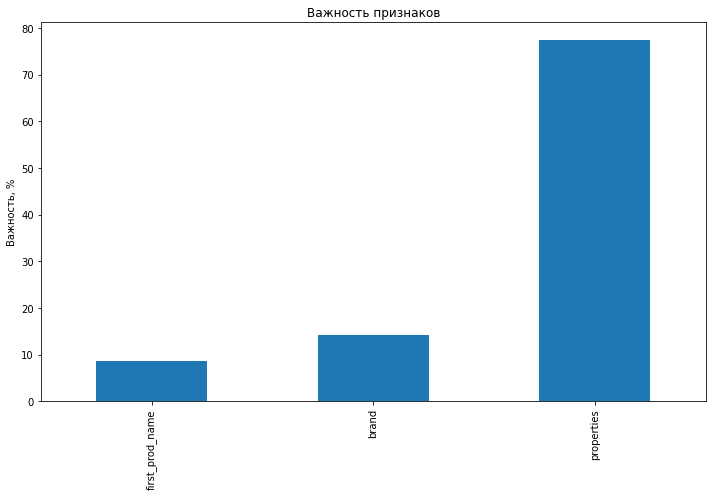

In [66]:
cat_imp = pd.Series(final_model.get_feature_importance(),
                         X_train.columns)
fig, ax = plt.subplots(figsize=(10,7))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [ ]:
# Исправление категорий вручную

In [64]:
res_df = new_df.groupby(['product_group_name']).agg({'main_category_name': ['nunique', set]}).reset_index()
res_sub_df = new_df.groupby(['product_group_name']).agg({'category_name': ['nunique', set]}).reset_index()
# Список продуктов с категорией  Рецепты
res_prod_list = res_df['product_group_name'].values
res_prod_list_sub = res_sub_df['product_group_name'].values

In [65]:
l = res_df['main_category_name']['set'].values
cat_list = []
for i, j in enumerate(l):
    cat = list(j)
    cat_list.append(cat)

In [66]:
np.unique(cat_list)

C:\Users\druzh\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


array([list(['Автотовары']),
       list(['Автотовары', 'Бытовая химия, уборка']), list(['Бакалея']),
       list(['Бытовая техника, электроника']),
       list(['Бытовая химия, уборка']), list(['Вода, соки, напитки']),
       list(['Вода, соки, напитки', 'Детские товары']),
       list(['Всё для ремонта']), list(['Готовая еда']),
       list(['Готовая еда', 'Консервы, соленья']), list(['Дача, сад']),
       list(['Дача, сад', 'Бытовая техника, электроника']),
       list(['Дача, сад', 'Товары для дома']), list(['Детские товары']),
       list(['Детские товары', 'Косметика, гигиена']),
       list(['Детские товары', 'Сладости']),
       list(['Замороженные продукты']),
       list(['Замороженные продукты', 'Готовая еда']),
       list(['Канцелярия, книги']),
       list(['Колбасы, сосиски, деликатесы']),
       list(['Консервы, соленья']), list(['Косметика, гигиена']),
       list(['Кухня']), list(['Кухня', 'Дача, сад']),
       list(['Кухня', 'Товары для дома']),
       list(['Молочны

In [61]:
check = res_df.loc[res_df['main_category_name']['set'] == {'Хлеб, выпечка', 'Косметика, гигиена'}, 'product_group_name']
check

65879    80 вишней пирожок хлебозавод
Name: product_group_name, dtype: object

In [62]:
new_df.loc[new_df['product_group_name'].str.contains('solemici корейка ломбо нарезка сыровяленая')]

,total_weight_kg,total_weight_flag,product_group_name_orig,product_group_name,index,_id,name_store,main_category_name,main_category_img_url,category_name,...,product_discount,product_max_stock_rate,product_discounted,product_unit_price,product_description,product_description_original,product_properties,slug_product_name,slug_main_category_name,slug_category_name


In [63]:
# Исправление категории
for i in check:
    new_df.loc[new_df['product_group_name'].str.contains(i), 'main_category_name'] = 'Хлеб, выпечка'

In [8]:
# Чтение из файла окончательного тренировочного датасета
df_train = pd.read_csv(DATASET_PATH)
df_train.head()

,product_price,total_weight_kg,total_weight_flag,main_category_name,brand,manufacturer,properties,first_prod_name,second_prod_name,last_name,eng_name
0,168.99,0.0,1,Всё для ремонта,KRONA,Химик ОАО,Очистители,обезжириватель,очистка,раствор,krona
1,279.00,0.0,1,Всё для ремонта,"То, что надо!",Окей ООО,Тросы,трос,прочистка,труба,-
2,89.99,0.5,0,Всё для ремонта,KRONA,KRONA,Растворители,обезжириватель,-,-,krona
3,168.99,0.0,1,Всё для ремонта,Химик,Химик ОАО,Растворители,керосин,химик,химик,-
4,126.99,0.0,1,Всё для ремонта,Fit,Технопласт ООО,Очки,очки,защитный,прозрачный,fit


In [63]:
# load the model from disk
model = pickle.load(open(MODEL_FILE_PATH, 'rb'))
# result = loaded_model.score(X_test, y_test)

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# model.plot_tree(
#     tree_idx=6,
#     pool=train_dataset)

In [18]:
# Дообучение модели???
model_3 = CatBoostClassifier(
    iterations=50,
    cat_features=CAT_FEATURE_NAMES)
model_3.fit( X_train, y_train,  init_model=model)

Learning rate set to 0.5
0:	learn: 0.0898411	total: 1.53s	remaining: 1m 14s
1:	learn: 0.0868951	total: 2.78s	remaining: 1m 6s
2:	learn: 0.0841046	total: 4.11s	remaining: 1m 4s
3:	learn: 0.0825519	total: 5.34s	remaining: 1m 1s
4:	learn: 0.0806888	total: 6.61s	remaining: 59.5s
5:	learn: 0.0795183	total: 7.84s	remaining: 57.5s
6:	learn: 0.0780613	total: 9.06s	remaining: 55.7s
7:	learn: 0.0772444	total: 10.3s	remaining: 53.9s
8:	learn: 0.0757709	total: 11.5s	remaining: 52.3s
9:	learn: 0.0745262	total: 12.8s	remaining: 51.1s
10:	learn: 0.0732352	total: 14s	remaining: 49.6s
11:	learn: 0.0721779	total: 15.2s	remaining: 48.2s
12:	learn: 0.0712571	total: 16.4s	remaining: 46.8s
13:	learn: 0.0705066	total: 17.7s	remaining: 45.5s
14:	learn: 0.0696248	total: 18.9s	remaining: 44.2s
15:	learn: 0.0688317	total: 20.2s	remaining: 43s
16:	learn: 0.0678381	total: 21.5s	remaining: 41.6s
17:	learn: 0.0666859	total: 22.7s	remaining: 40.3s
18:	learn: 0.0659409	total: 23.9s	remaining: 39s
19:	learn: 0.0653148	

In [23]:
evaluate_preds(model_3, X_train, X_test, y_train, y_test)

TRAIN

                                                precision    recall  f1-score   support

                                    Автотовары       0.99      0.99      0.99       351
                                       Бакалея       0.99      1.00      1.00       750
                  Бытовая техника, электроника       0.99      1.00      0.99       515
                         Бытовая химия, уборка       0.96      0.99      0.98       577
                           Вода, соки, напитки       0.96      0.97      0.97       601
                               Всё для ремонта       1.00      1.00      1.00       224
                                   Готовая еда       0.96      0.91      0.93       125
                                     Дача, сад       0.97      0.99      0.98      1120
                                Детские товары       0.98      0.93      0.95      1981
                         Замороженные продукты       0.96      0.96      0.96       547
                        